In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import os
from scipy.signal import lfilter

In [2]:
#selbe funktion wie oben - mit dem Unterschied, dass Einträge mit Messwerten die größer als 190 sind gelöscht werden

def cleaning_del(df):
    
    new = pd.DataFrame()
    #setting device id to join multiple bins later in the process
    new['device_id'] = df['deveui']
    #seeting time stamp
    new['time_stamp'] = pd.to_datetime(df['created_at'], format='%Y-%m-%d')    
    #deleting rows with values height > 190 -> Measurement errors
    new['Height'] = df['Height'].str.replace('cm', '').astype(int)
    new = new[new.Height < 190]
    
    #casting temperature to int and replace values > 100 with NaN
    new['Temperature'] = df['Temperature'].str.replace('C', '').astype(int)
    new.loc[(new.Temperature > 100), 'Temperature'] = np.nan
    #casting Tilt to int
    new['Tilt'] = df['Tilt'].str.replace('Degree', '').astype(int)
    #sorting values acording to time_stamp
    new.sort_values(by=['time_stamp'], ascending=True, inplace = True)

    return new

In [3]:
def smoothing(df):
     
    #smooth with lfilter
    n = 60  # the larger n is, the smoother curve will be
    b = [1.0 / n] * n
    a = 1
    df['lfilter'] = lfilter(b,a, df['Height'])

    #moving average smoothing
    df['mov_avg'] = df['Height'].rolling(60).mean()

    #minimum moving average
    df['min_avg'] = df['Height'].rolling(60).min()

    
    #creating new DataFrame on Level Daily with aggregation max()
    daily = df.groupby(pd.Grouper(key='time_stamp', axis=0, 
                        freq='1D', sort=True)).mean()
    #add device_id
    daily['device_id'] = df.iloc[1, 0]

    #further smoothing on daily level with rolling mean window 2
    daily['mov_avg'] = daily['Height'].rolling(2).mean()

    #fill missing values with interpolation
    df['inter_pol'] = df['mov_avg'].interpolate(limit_direction = 'both')
    daily['inter_pol'] = daily['mov_avg'].interpolate(limit_direction = 'both')
    daily.inter_pol.fillna(method = 'backfill', inplace = True)

    #fill missing NaN in DeviceID
    daily['device_id'].fillna(method = 'bfill', inplace=True)

    #fill Temperature NaN with average
    daily.Temperature.fillna(value = df.Temperature.mean(), inplace = True)
    #fill Tilt NaNs with mean
    daily.Tilt.fillna(value = daily.Tilt.mean(), inplace = True)

    return df, daily

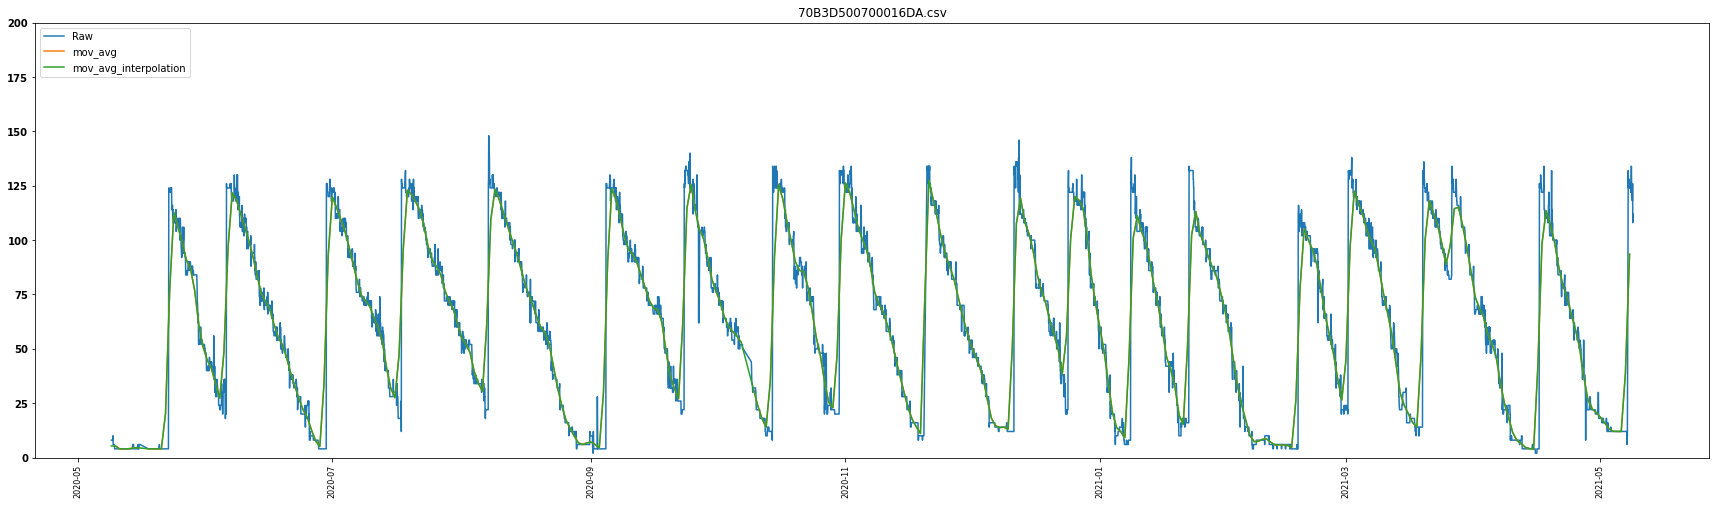

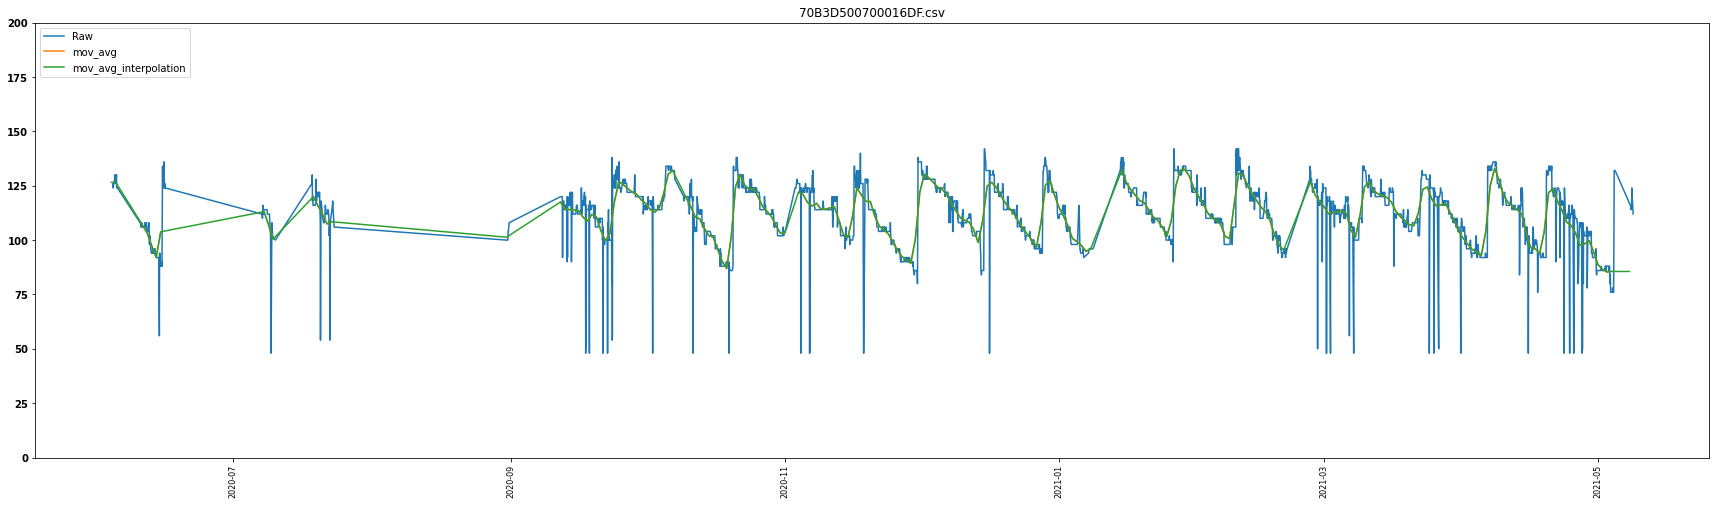

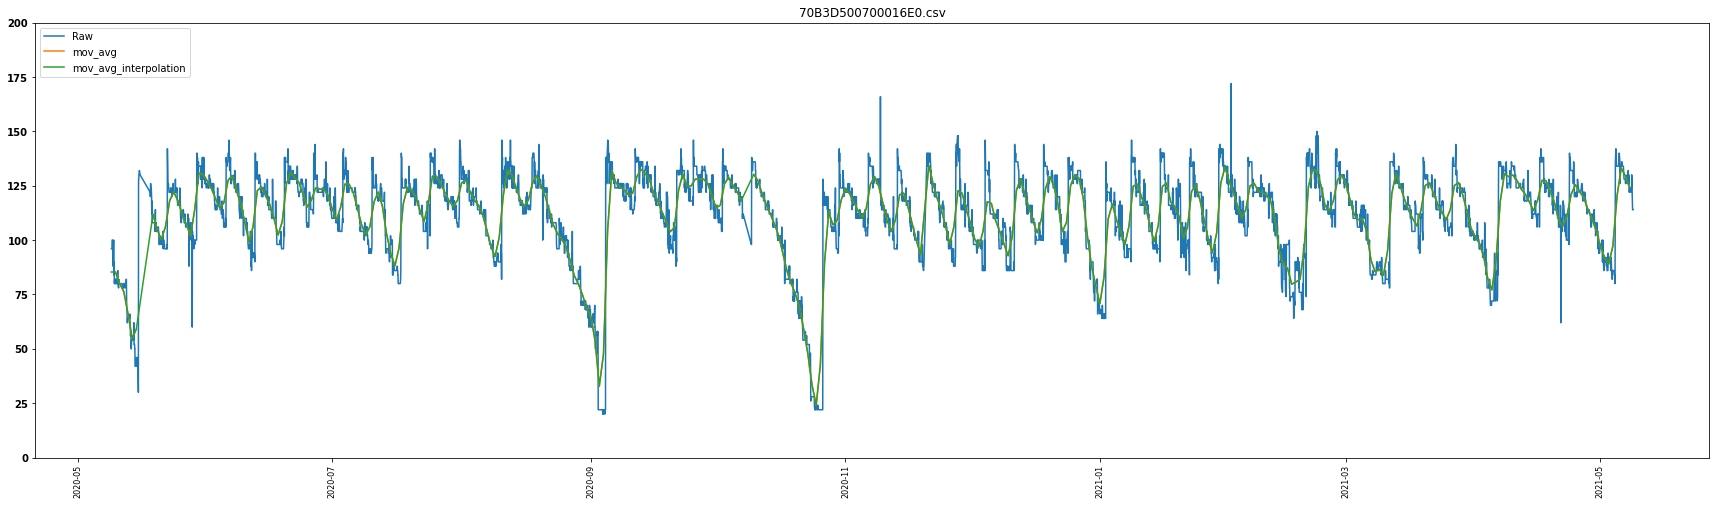

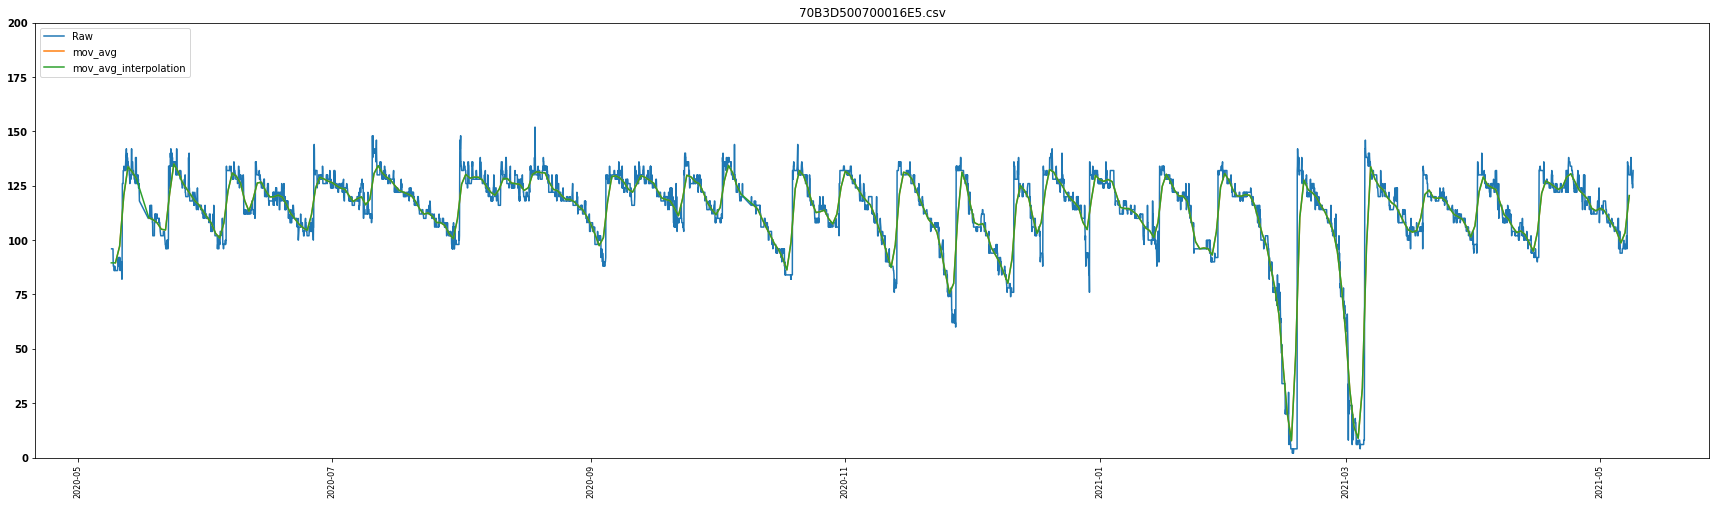

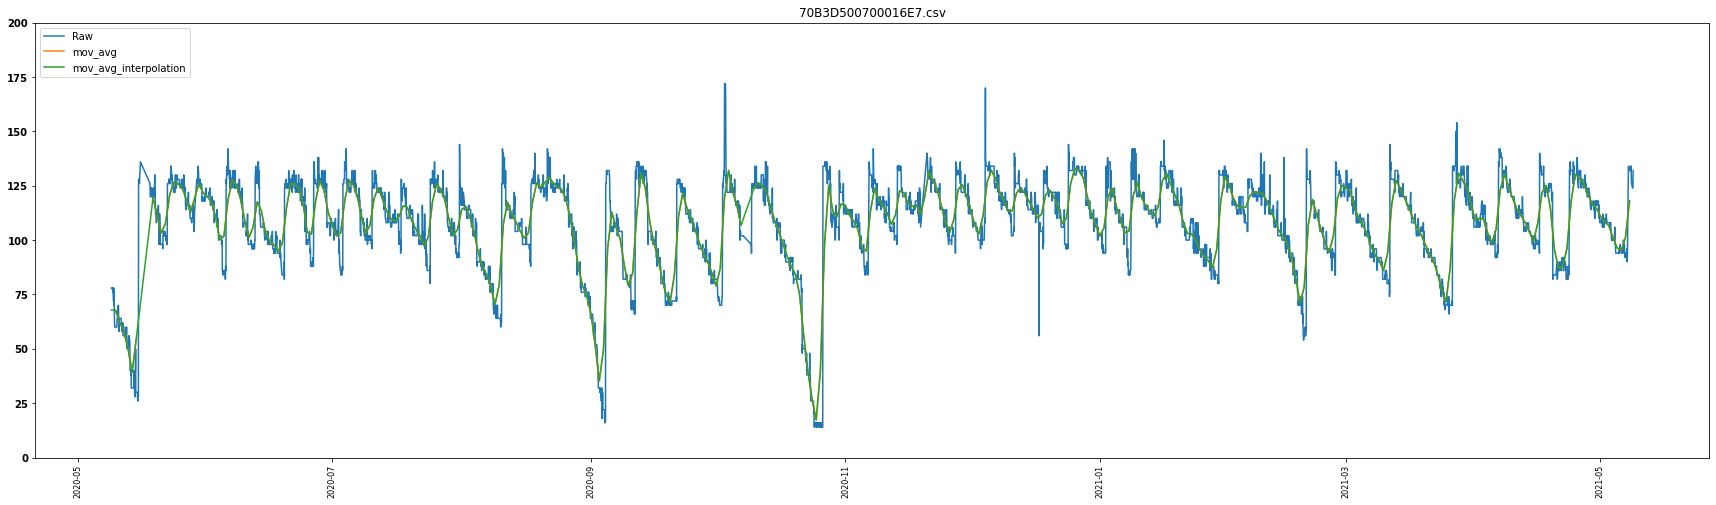

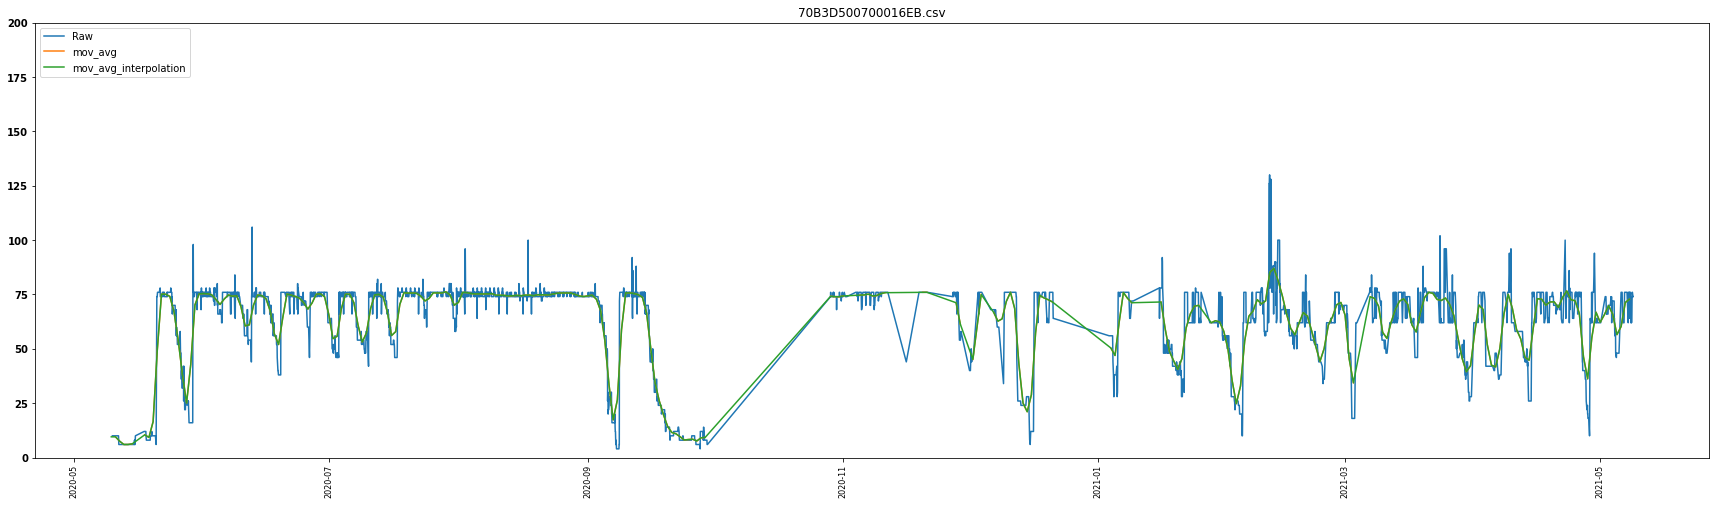

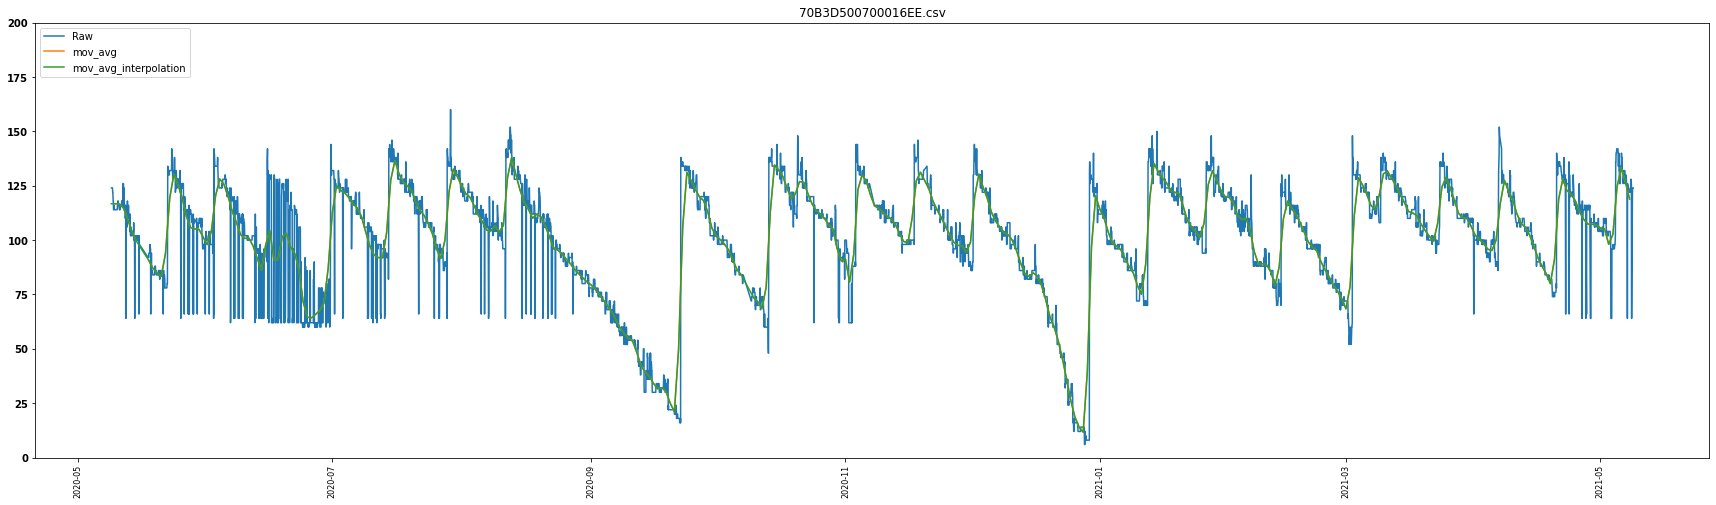

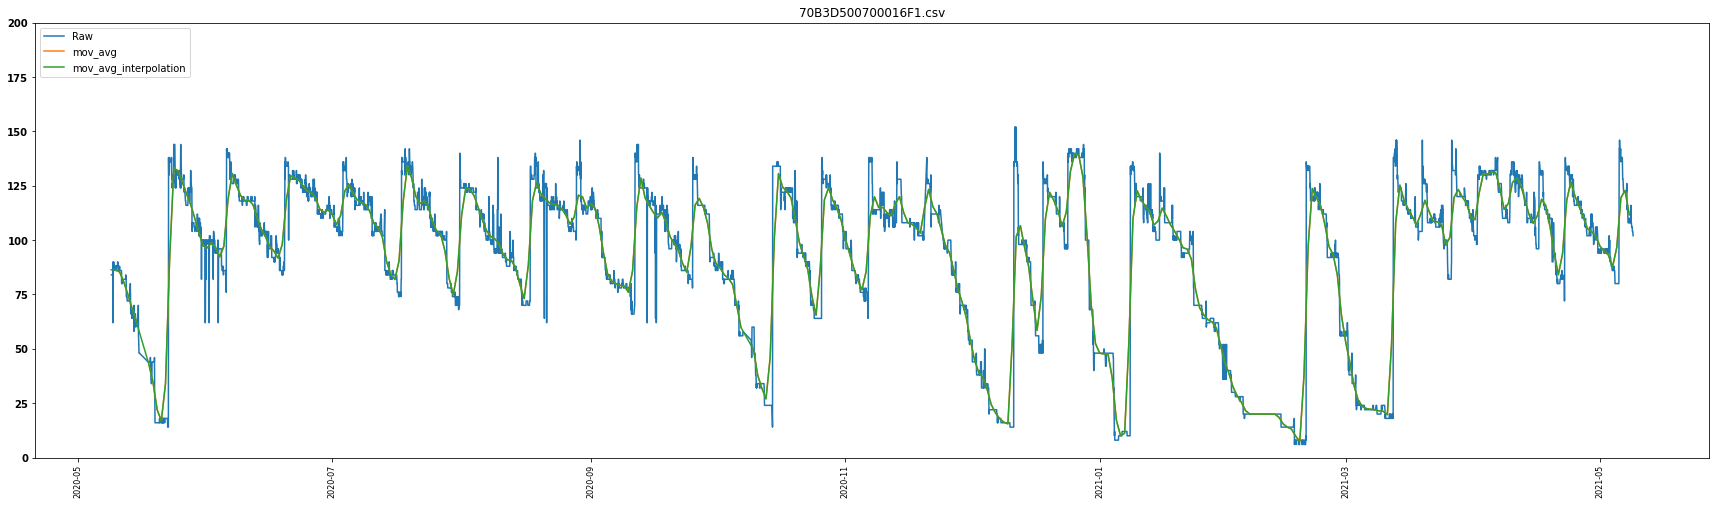

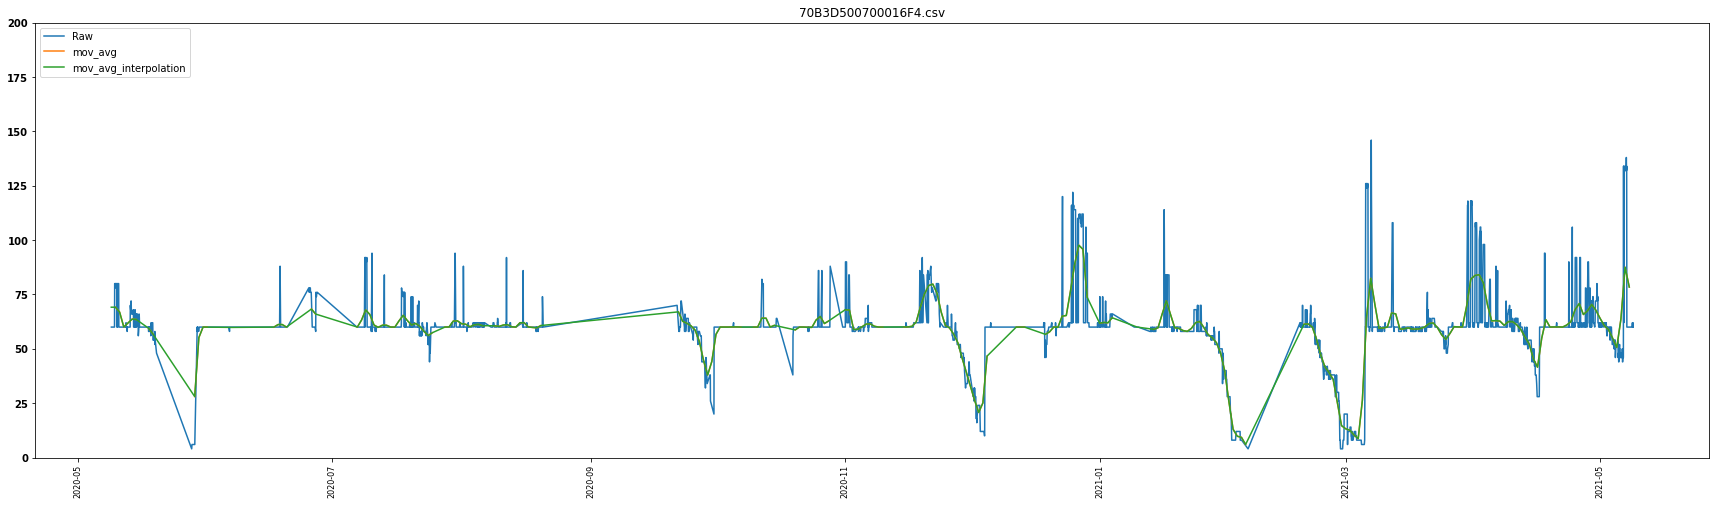

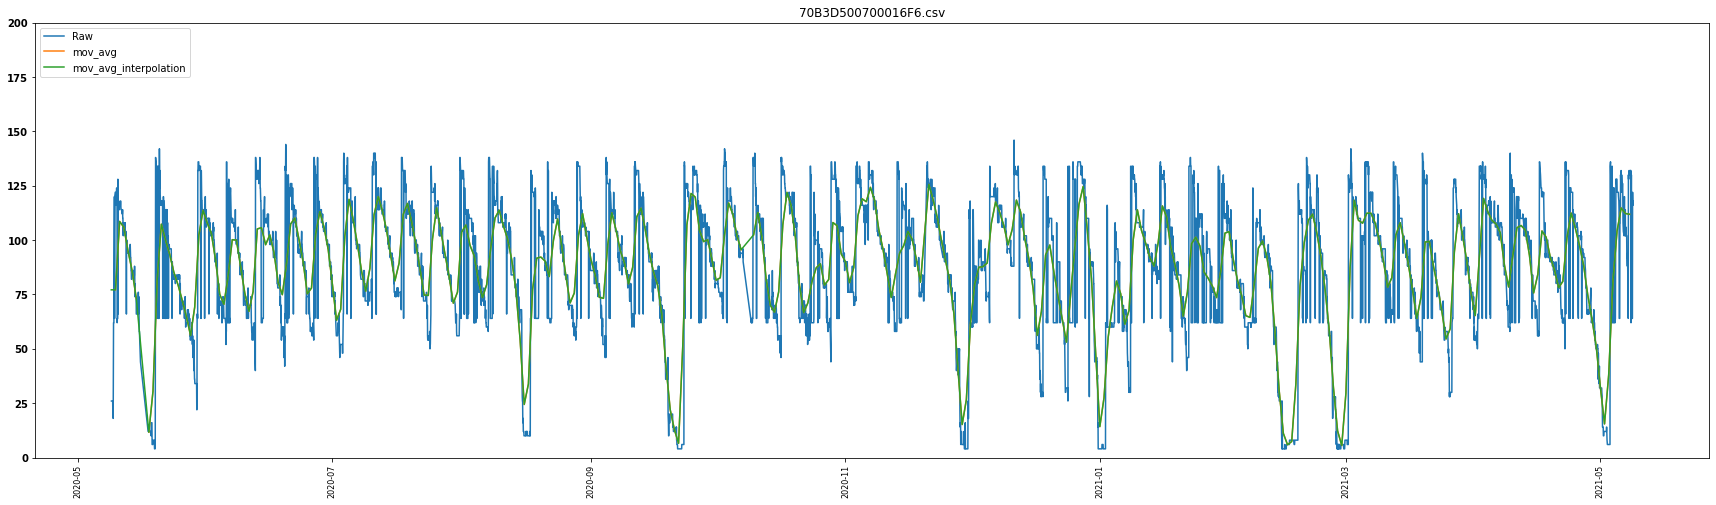

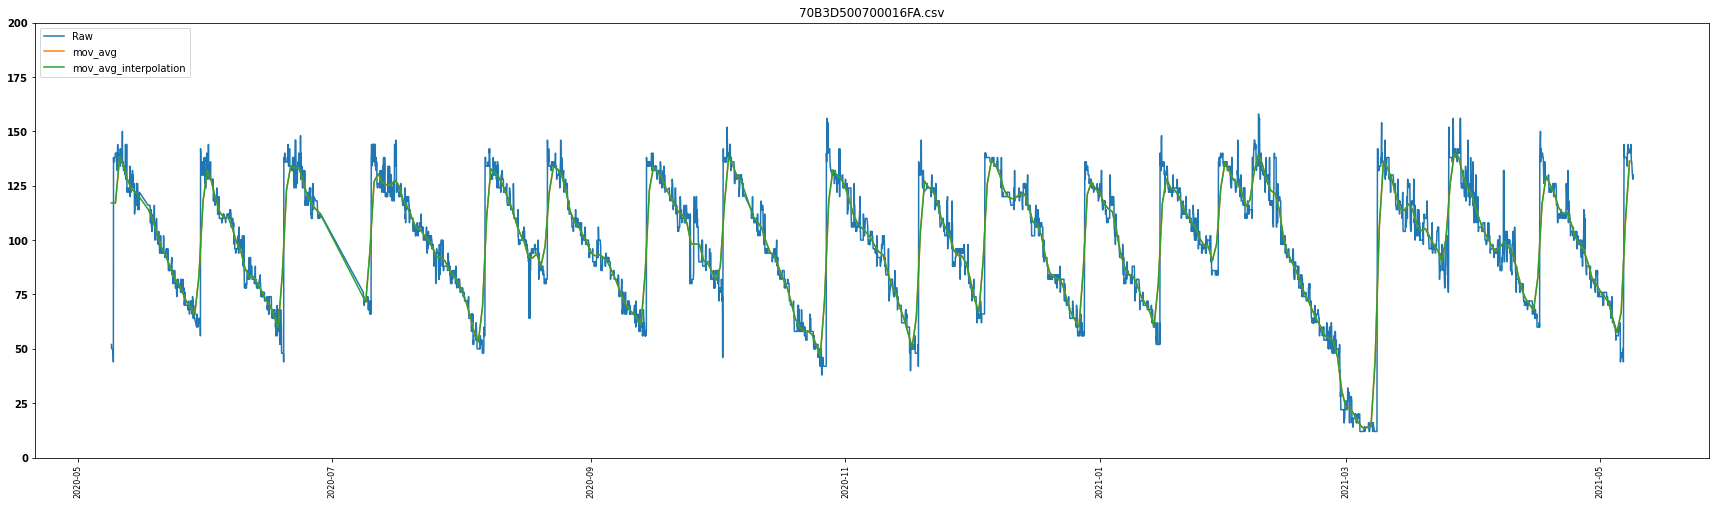

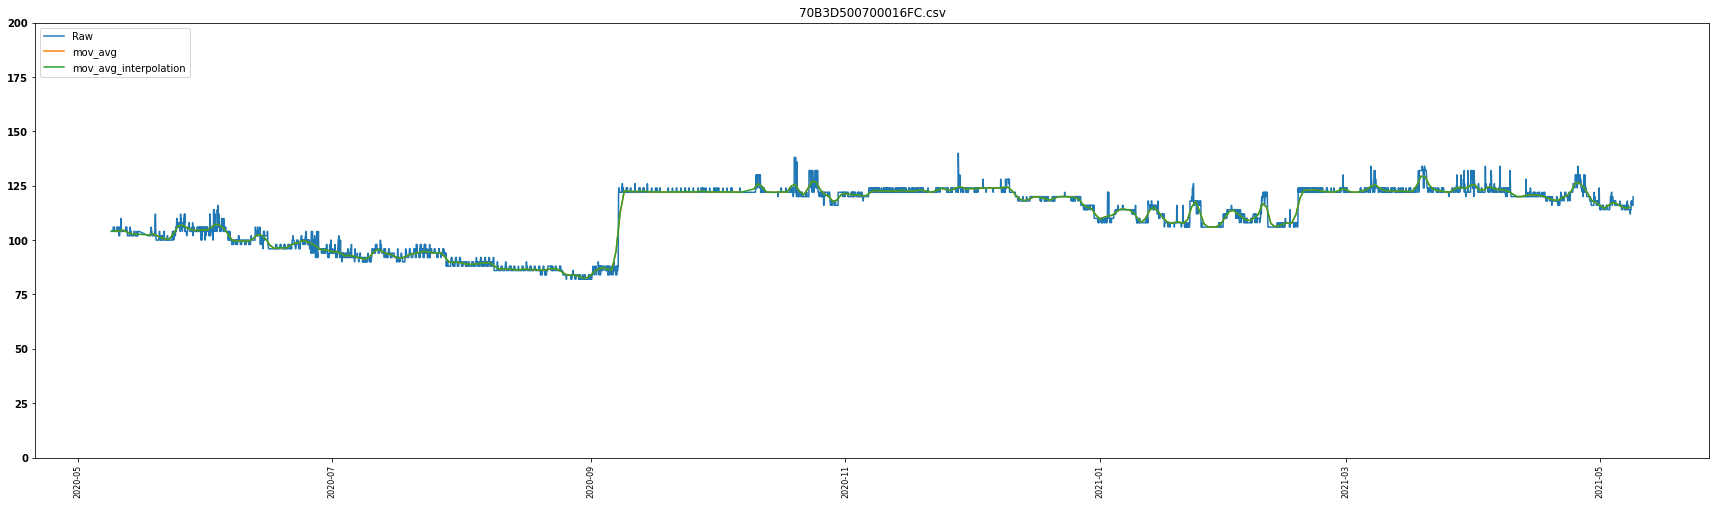

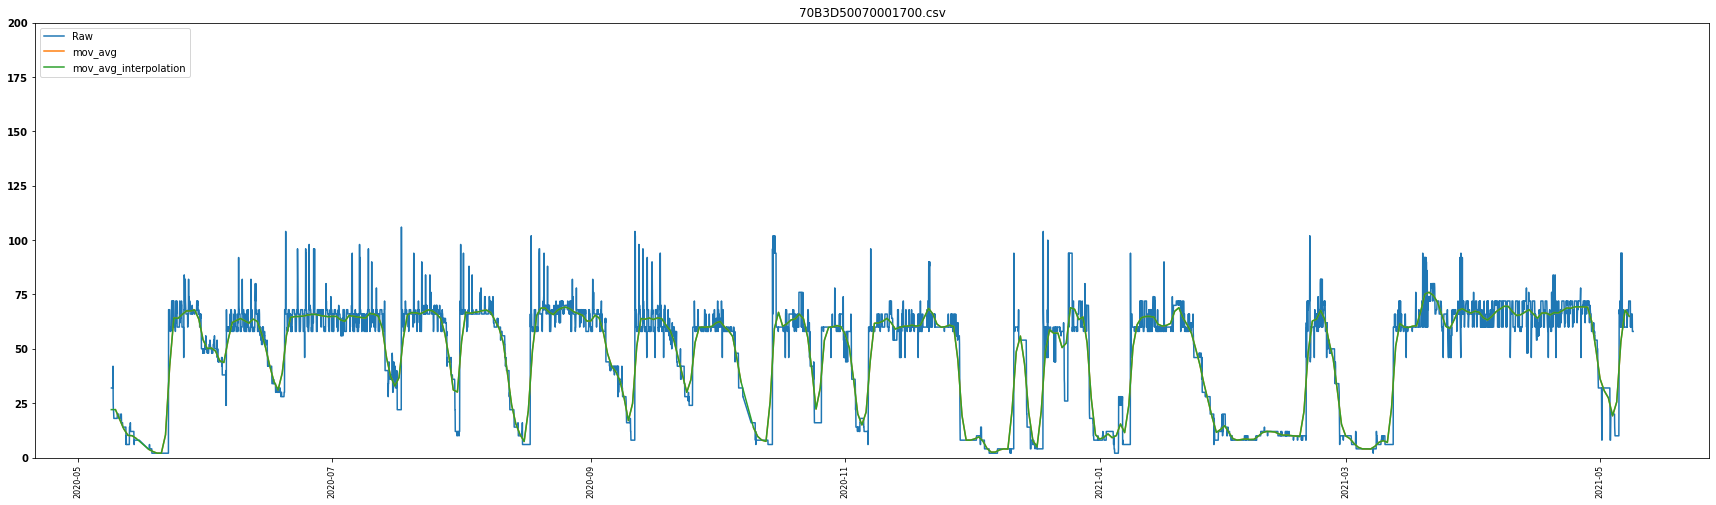

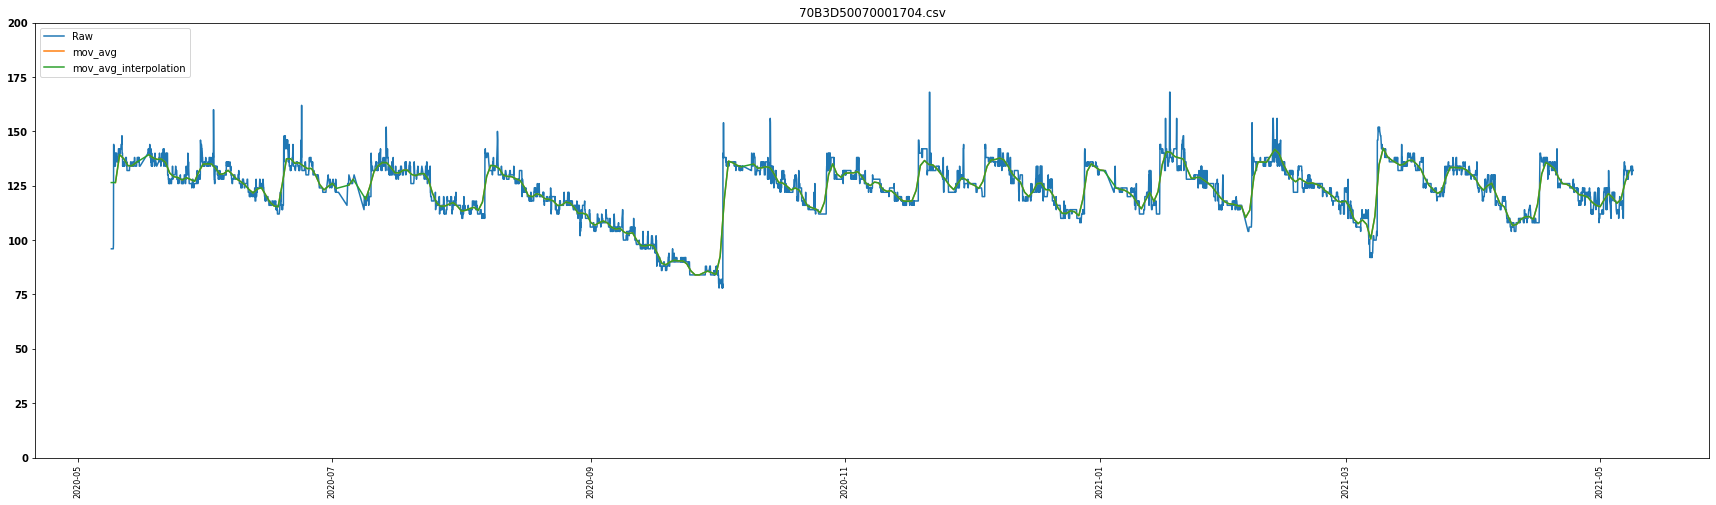

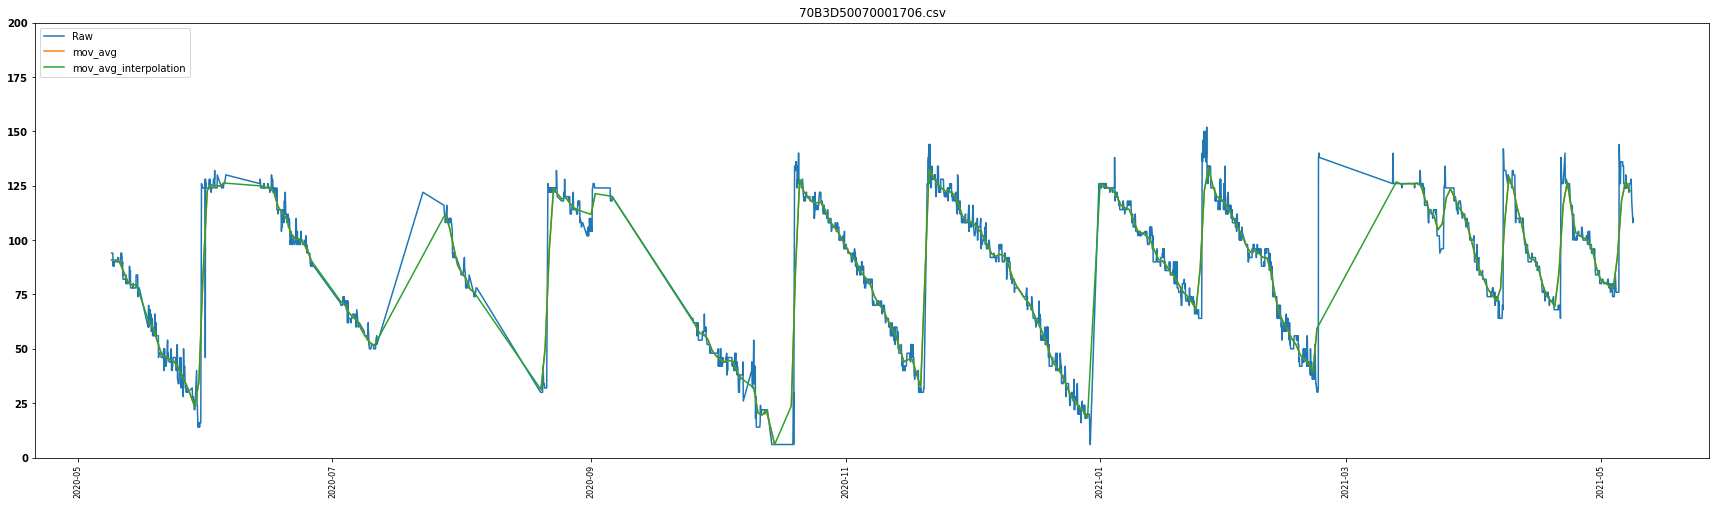

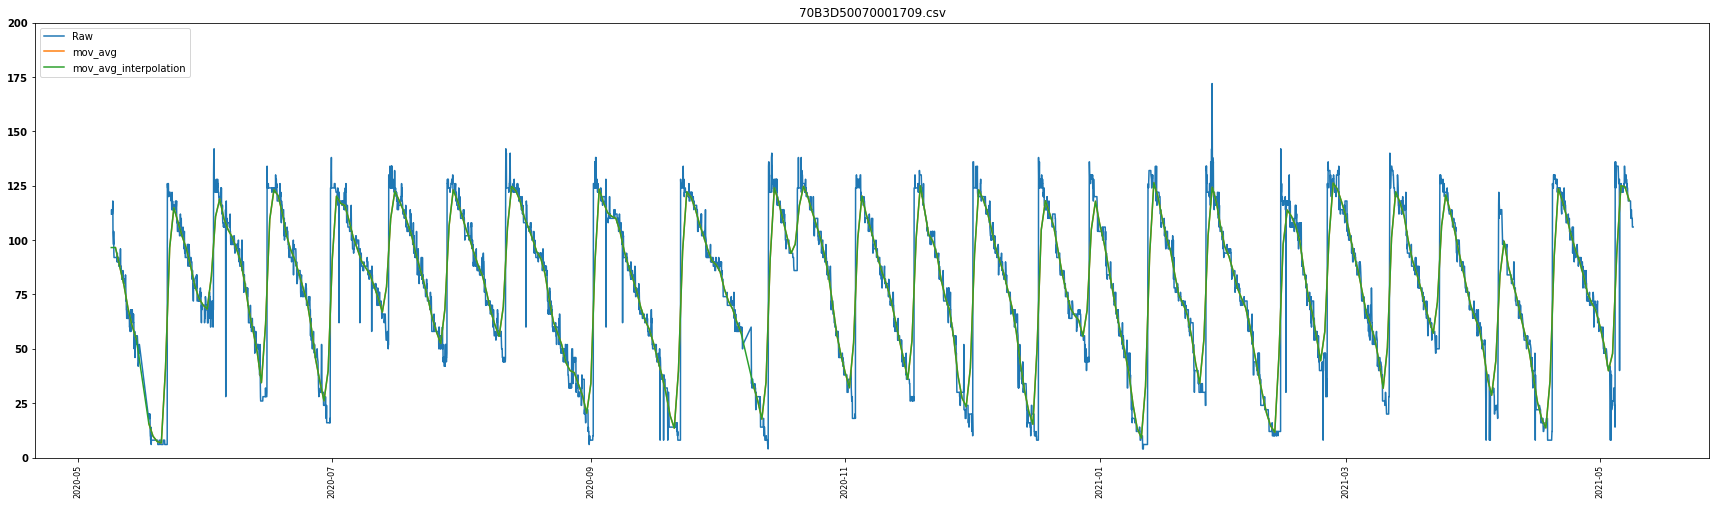

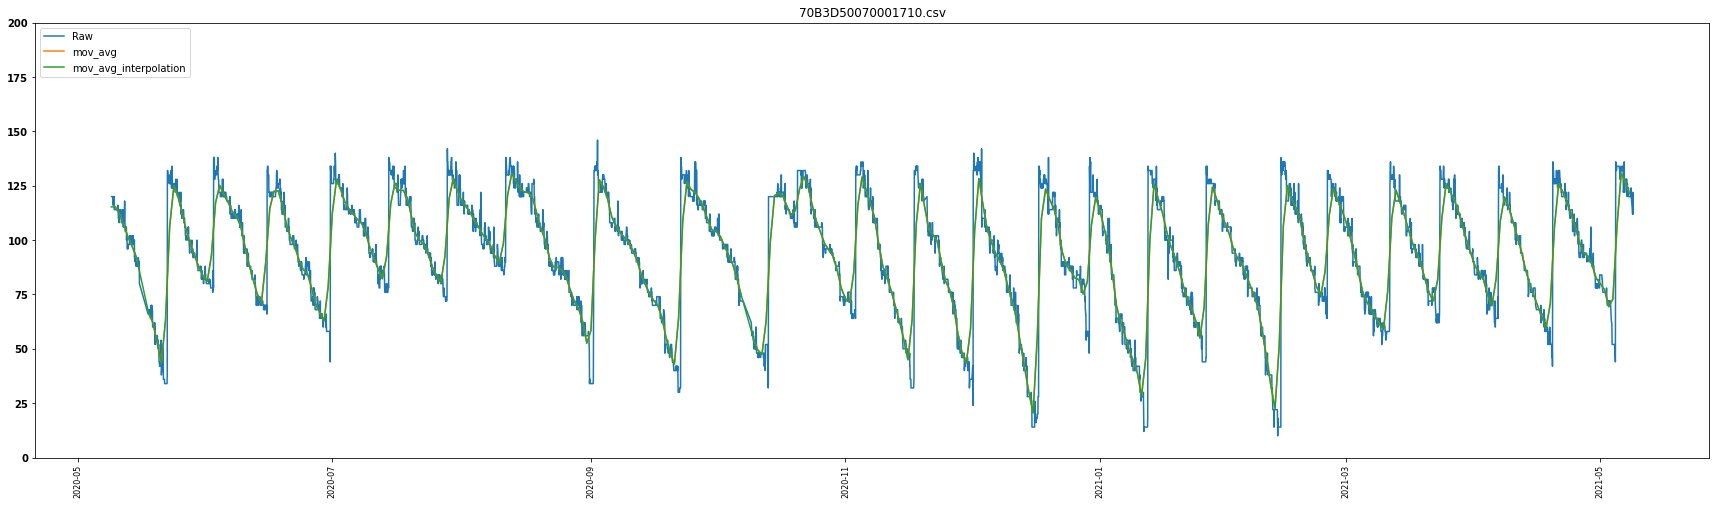

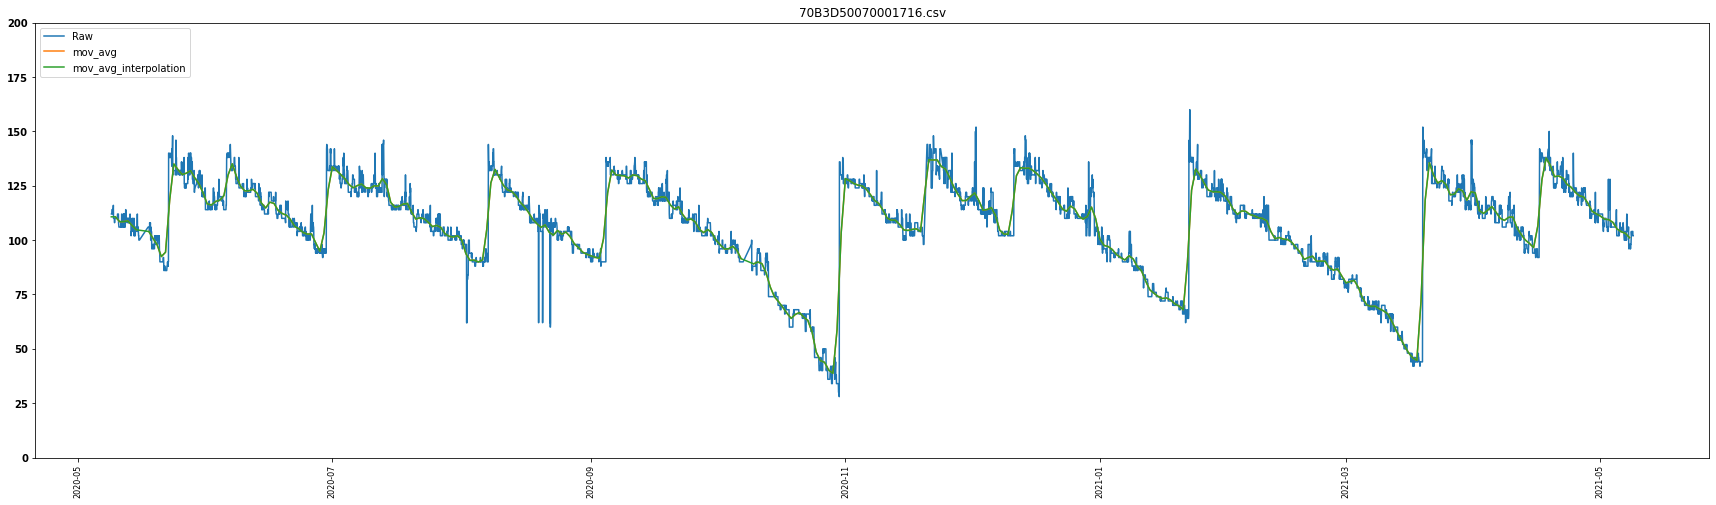

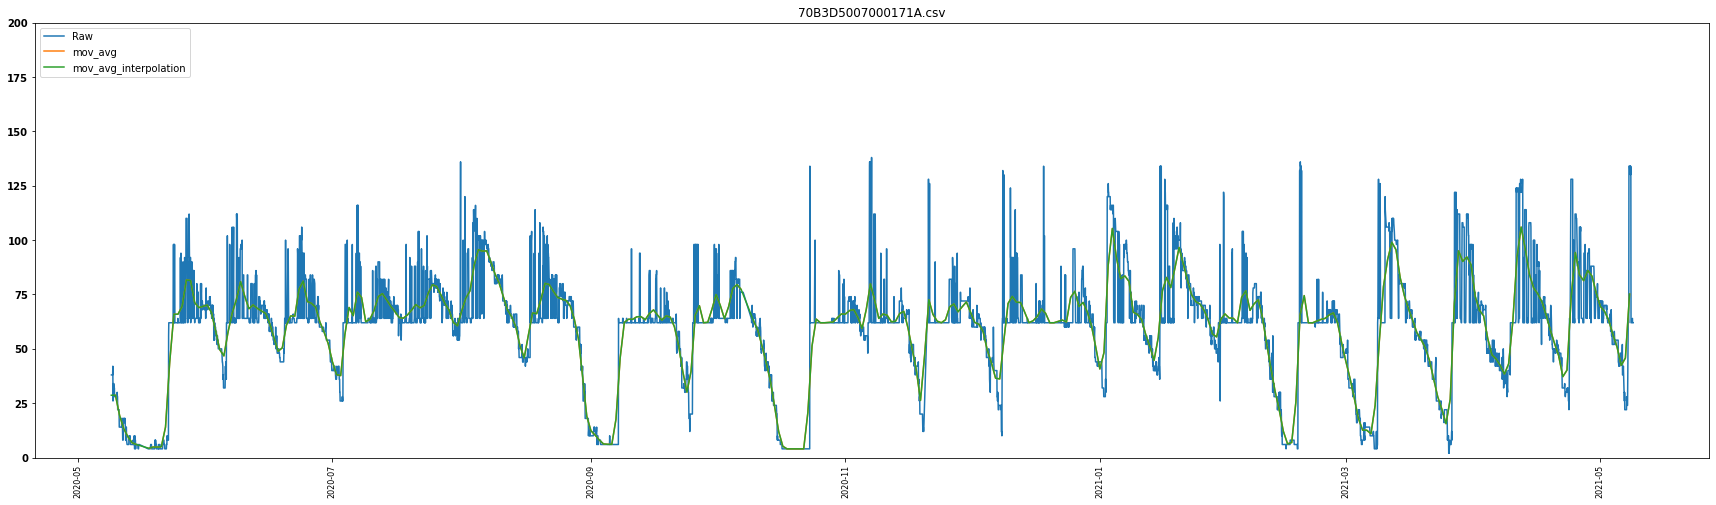

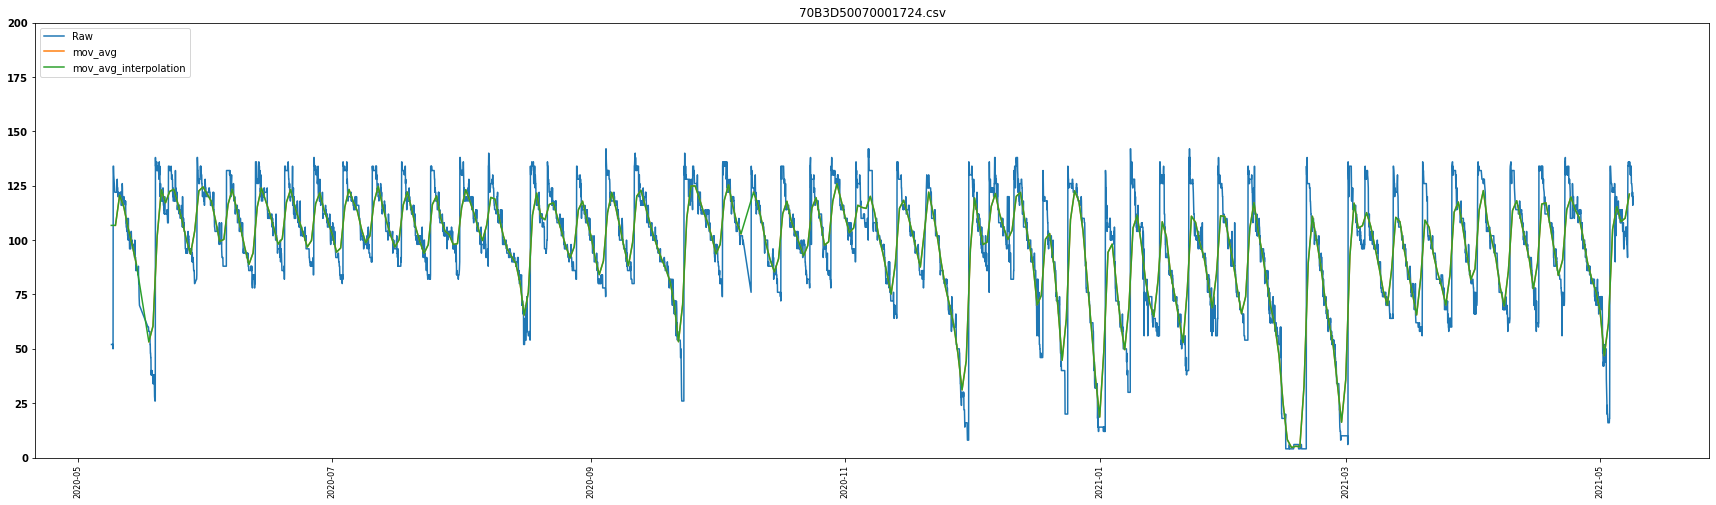

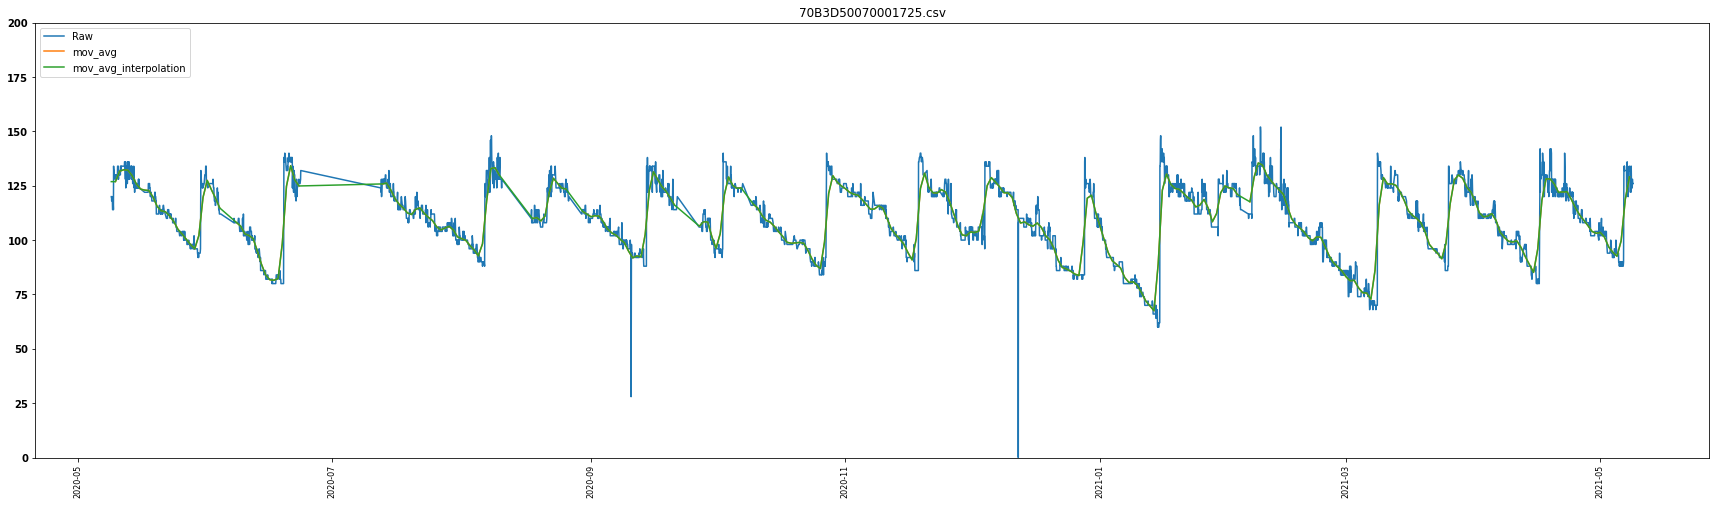

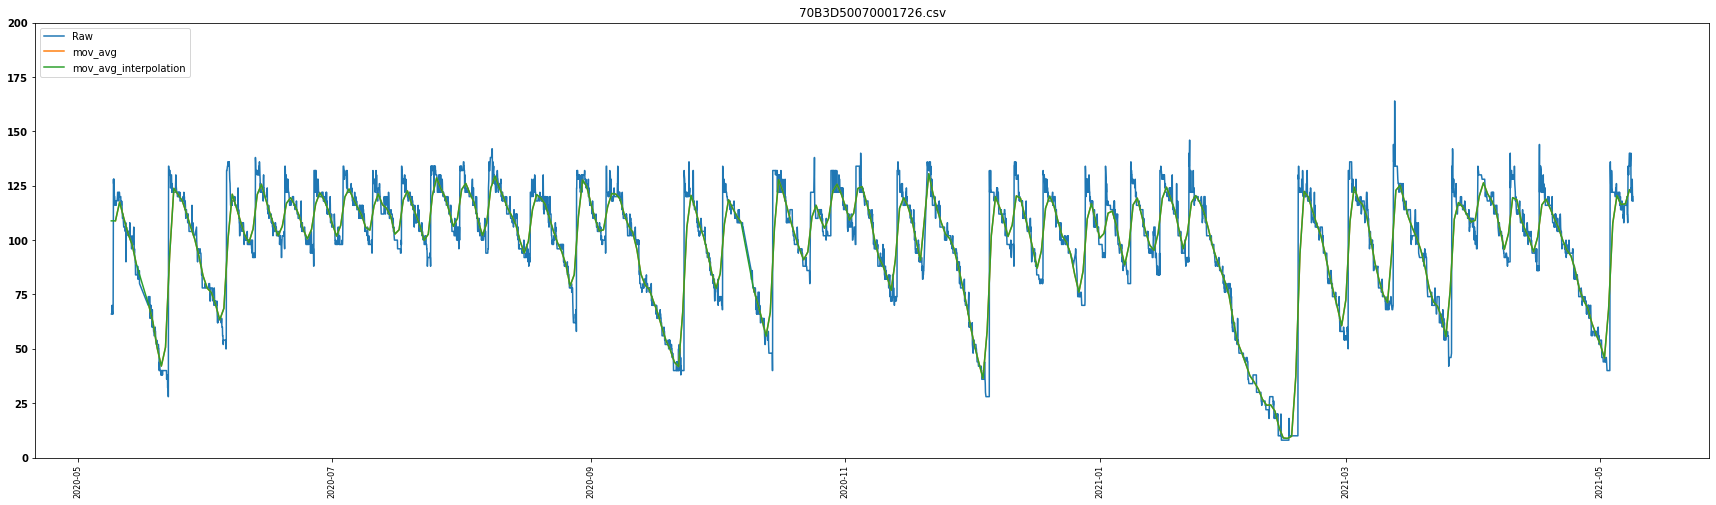

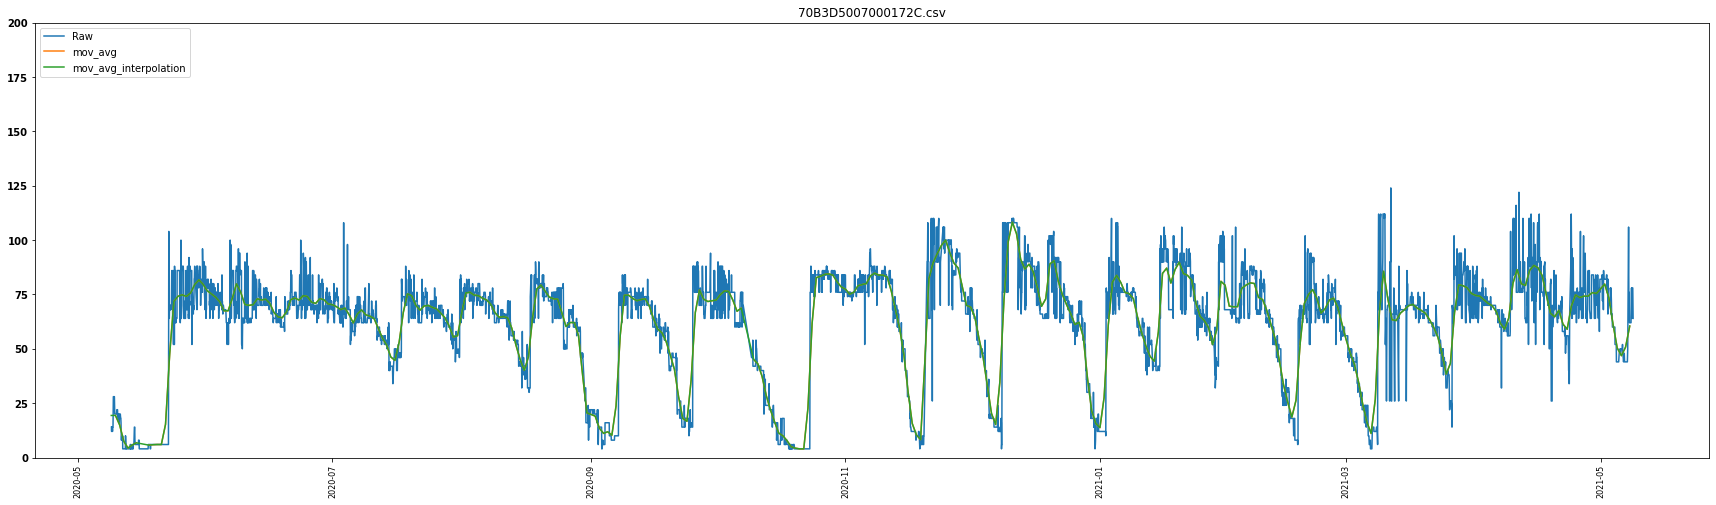

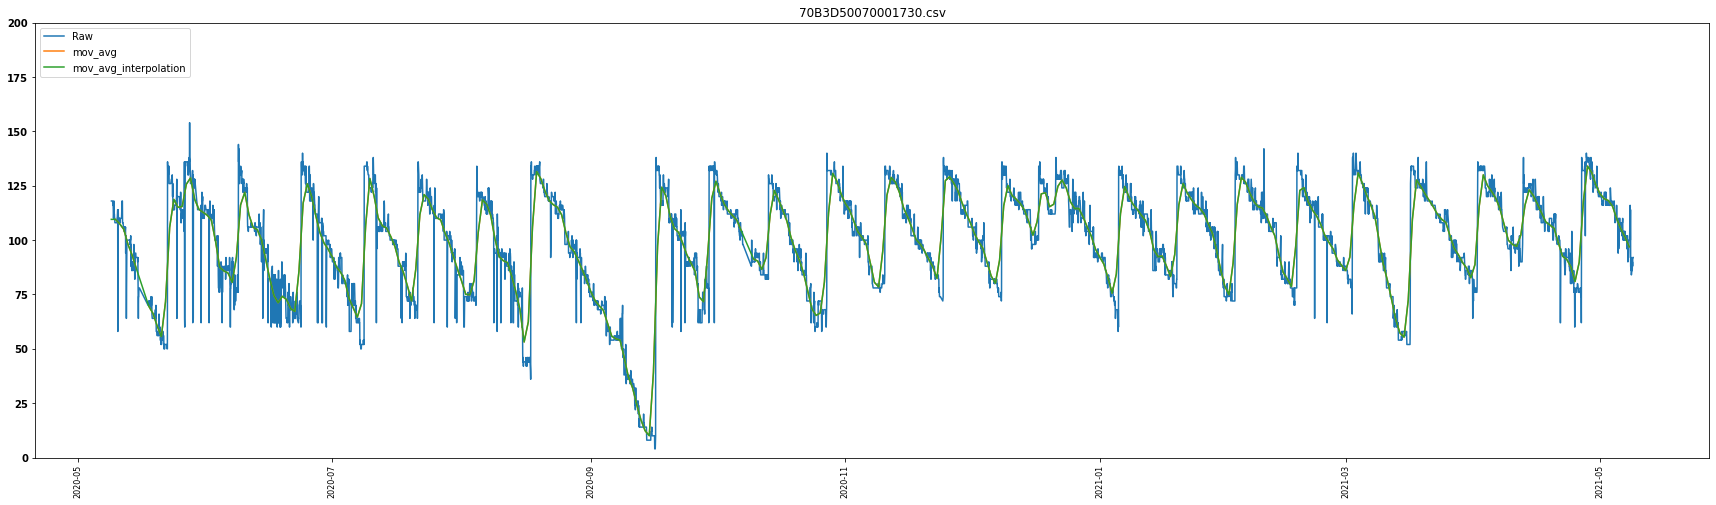

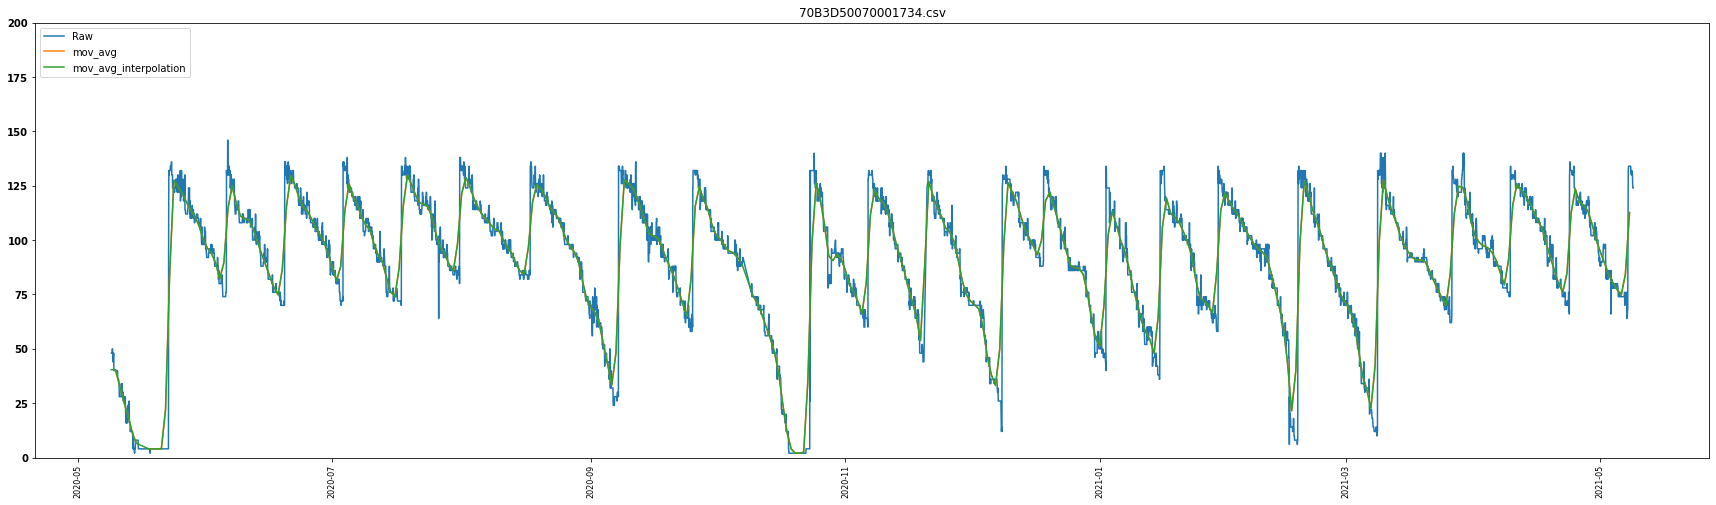

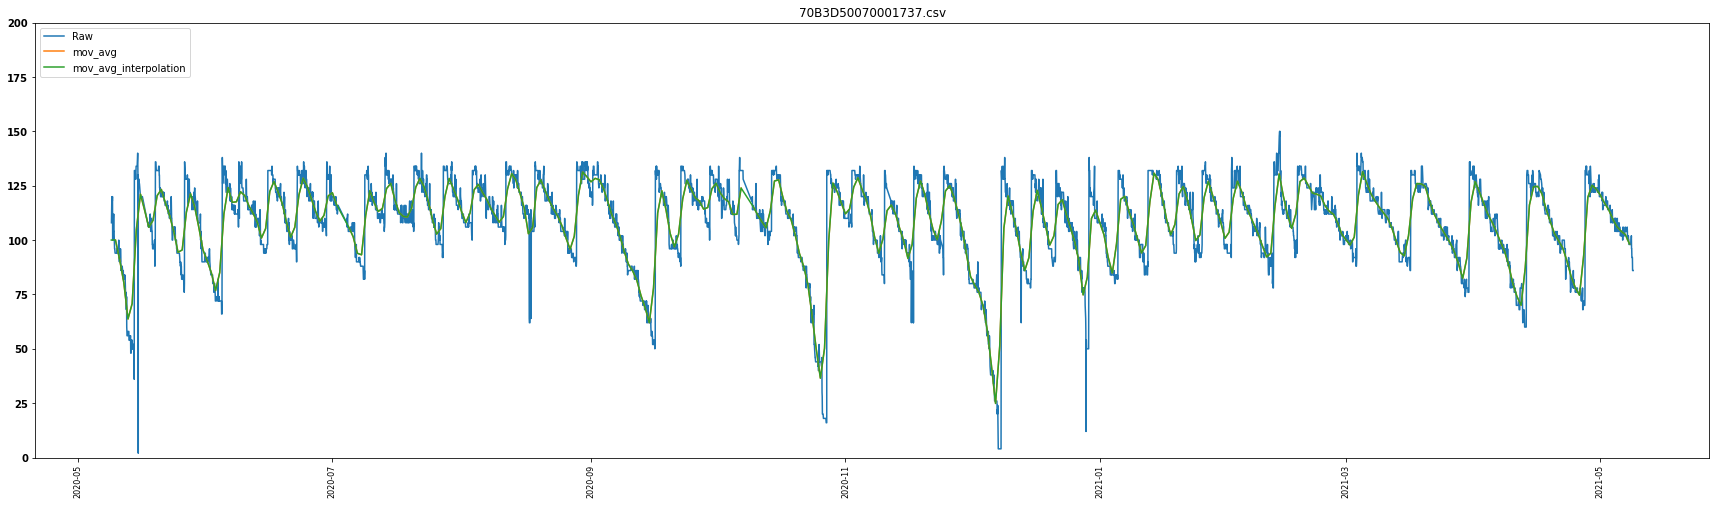

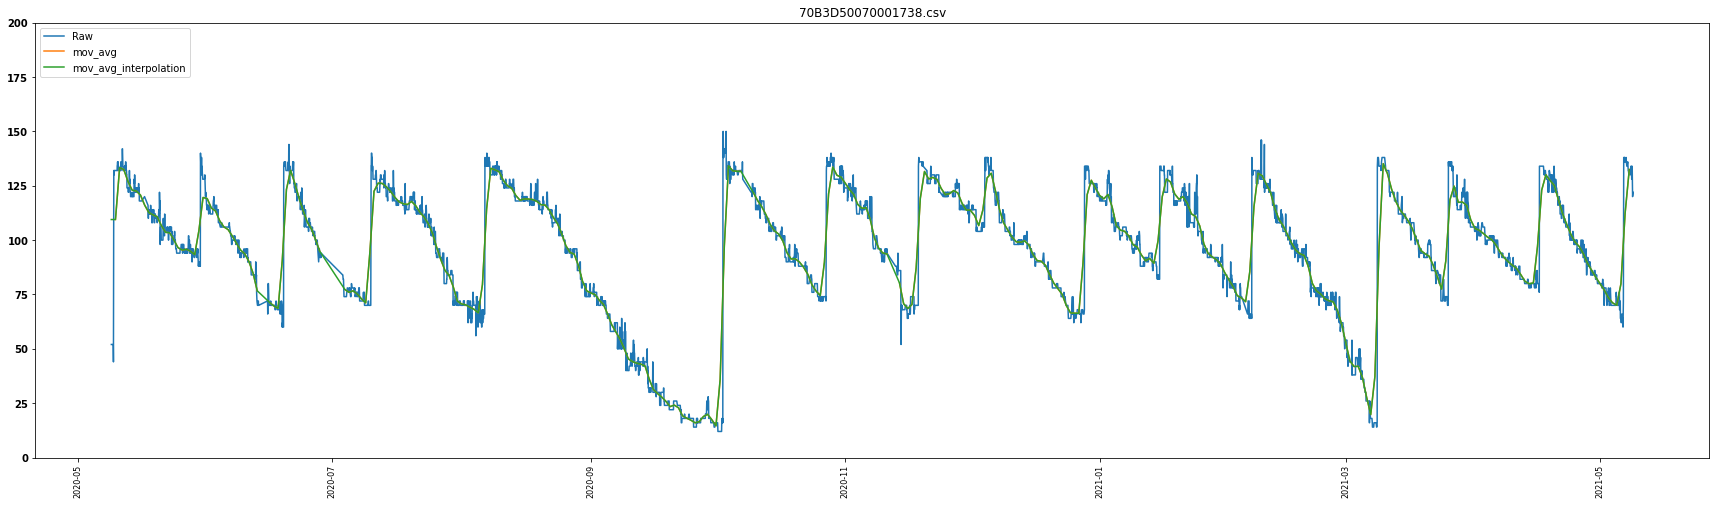

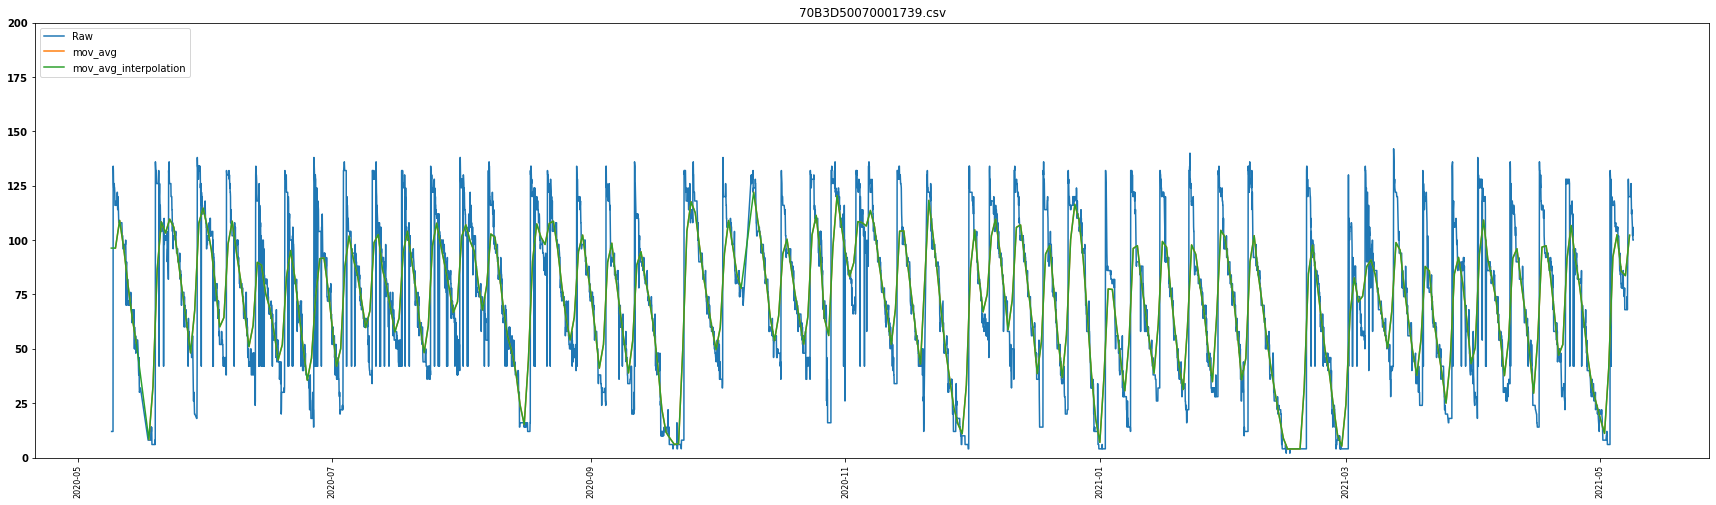

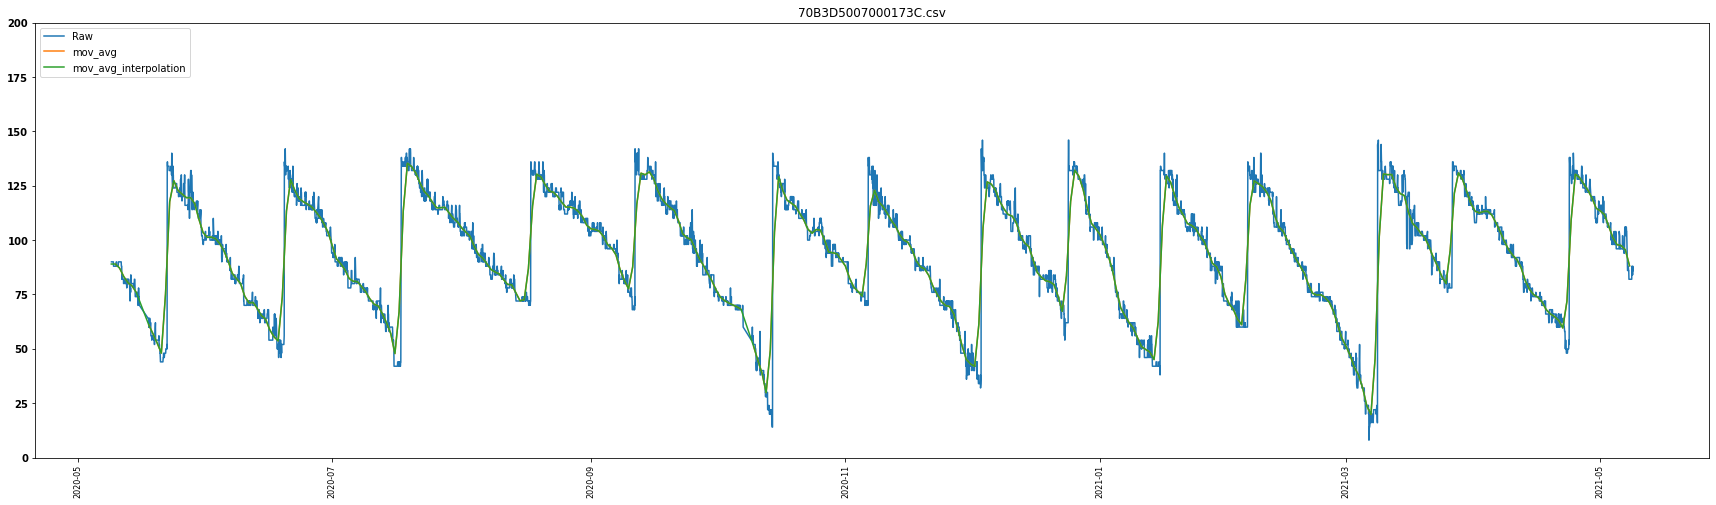

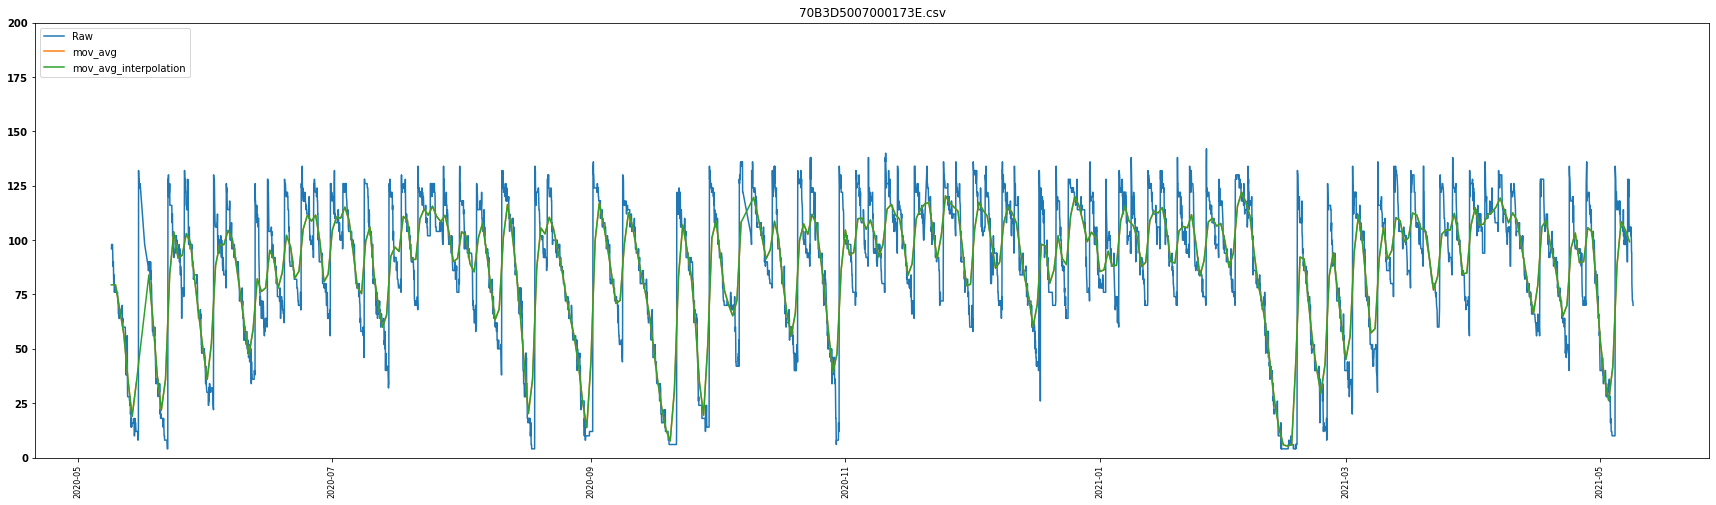

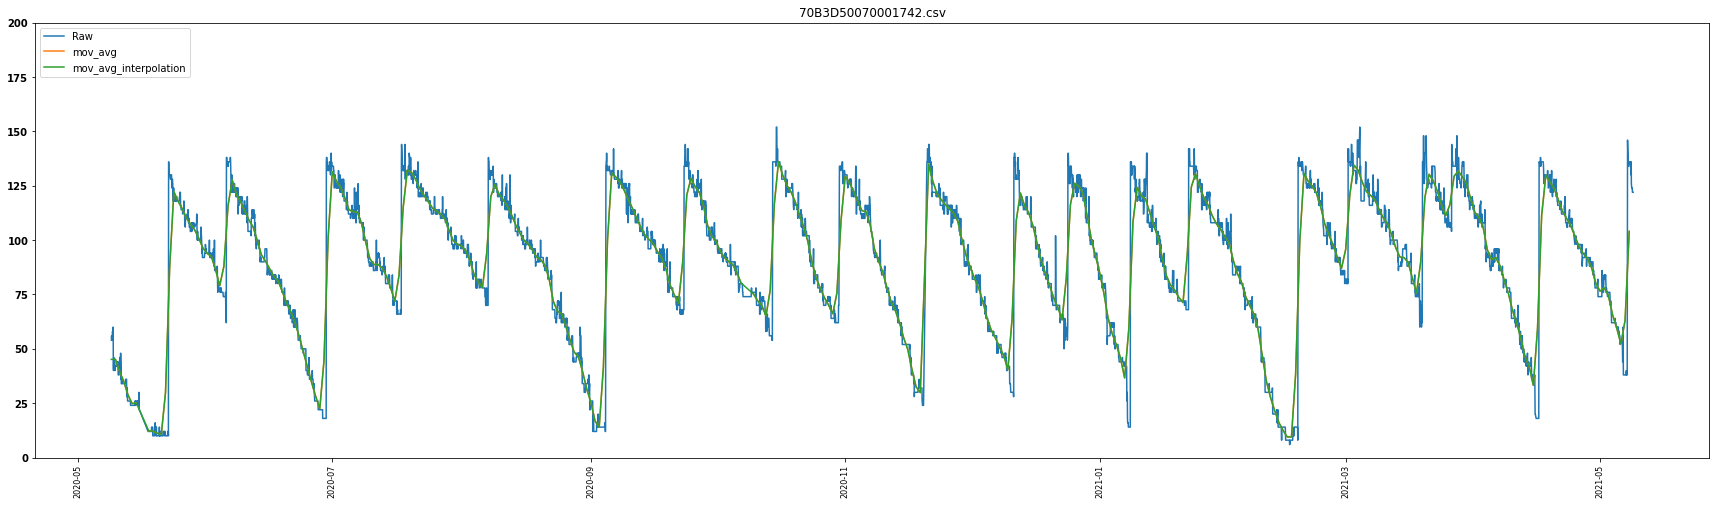

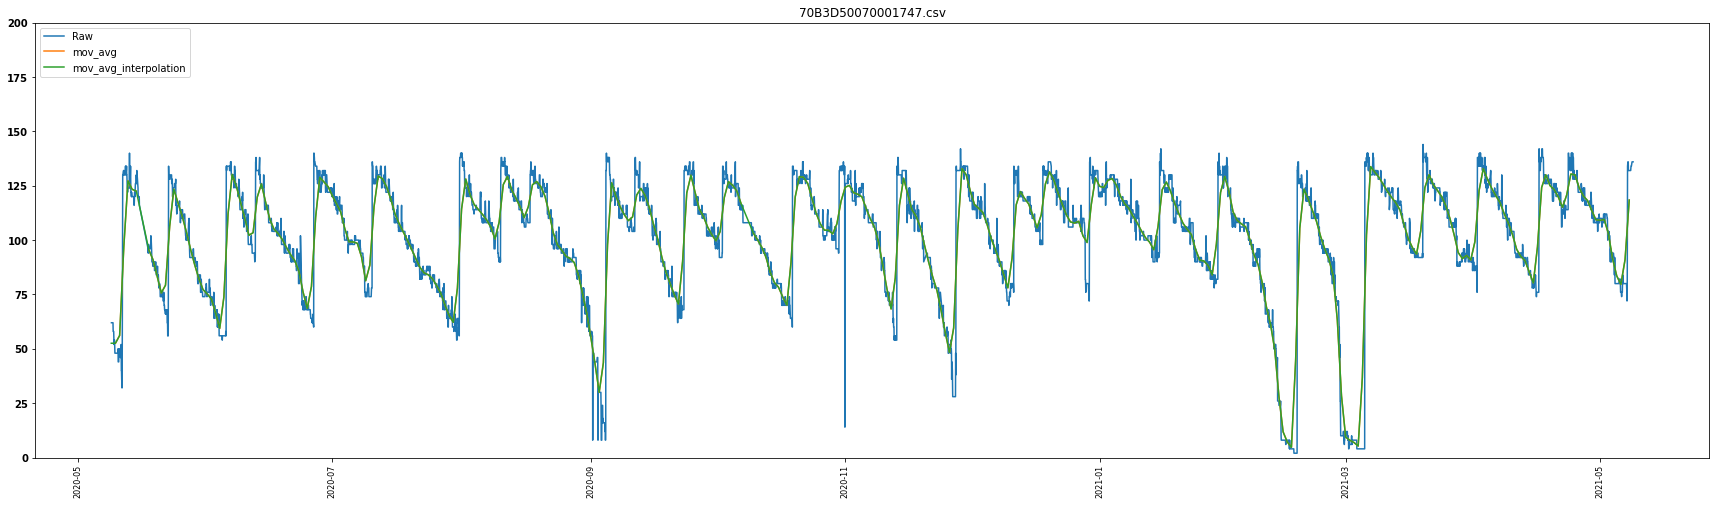

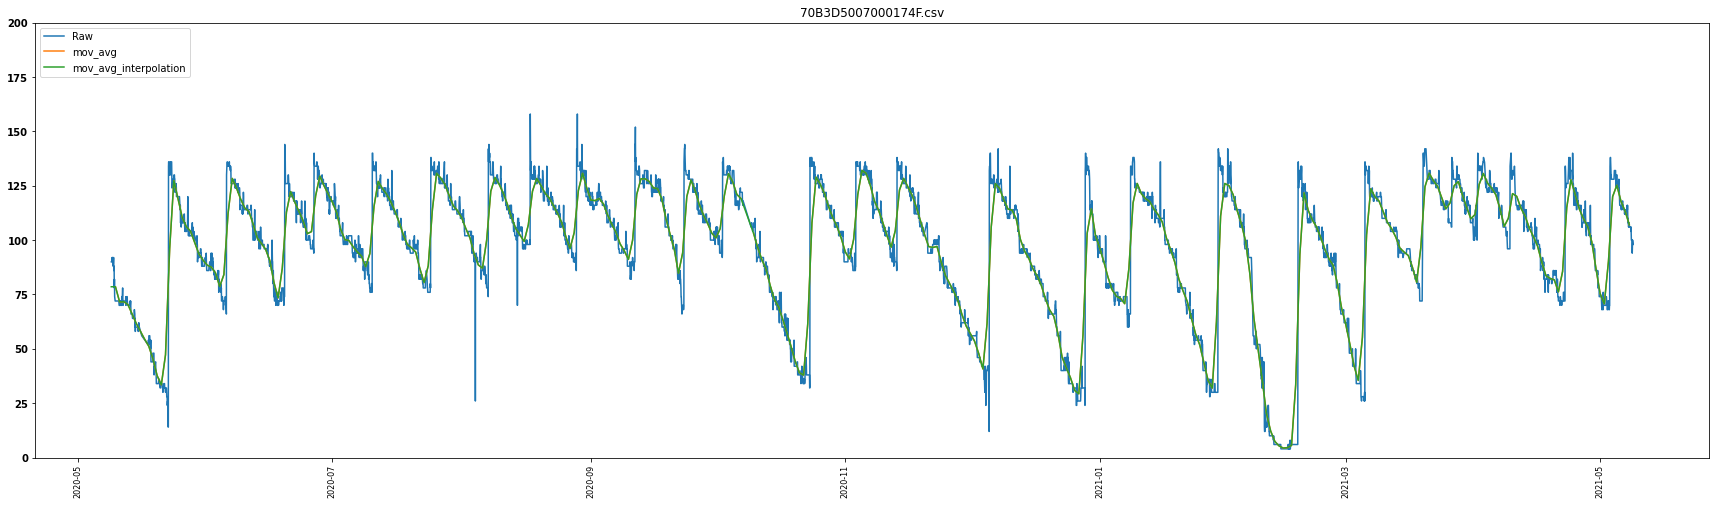

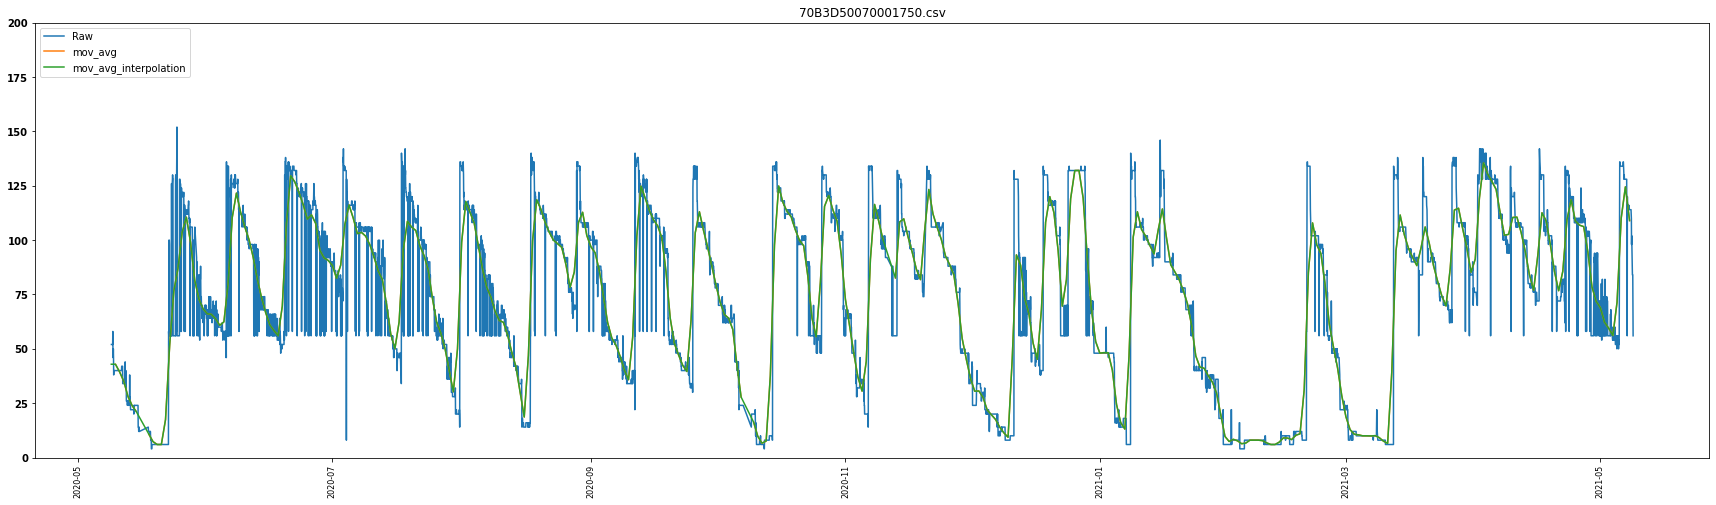

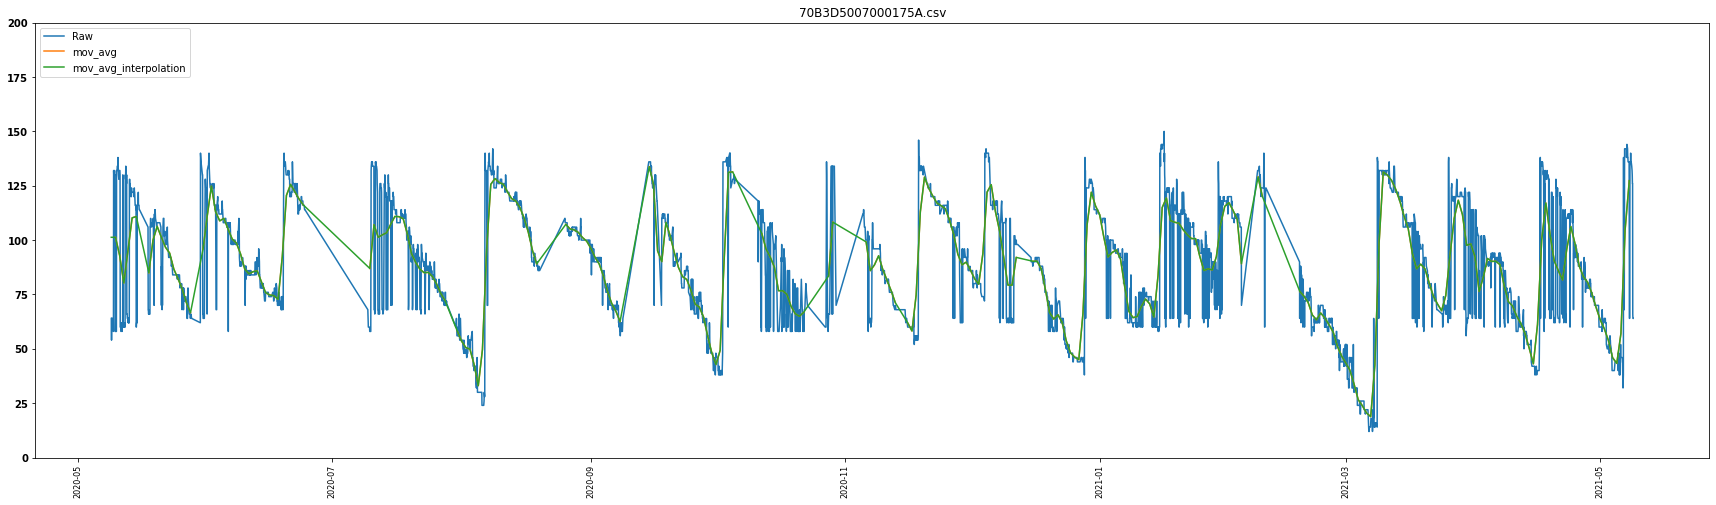

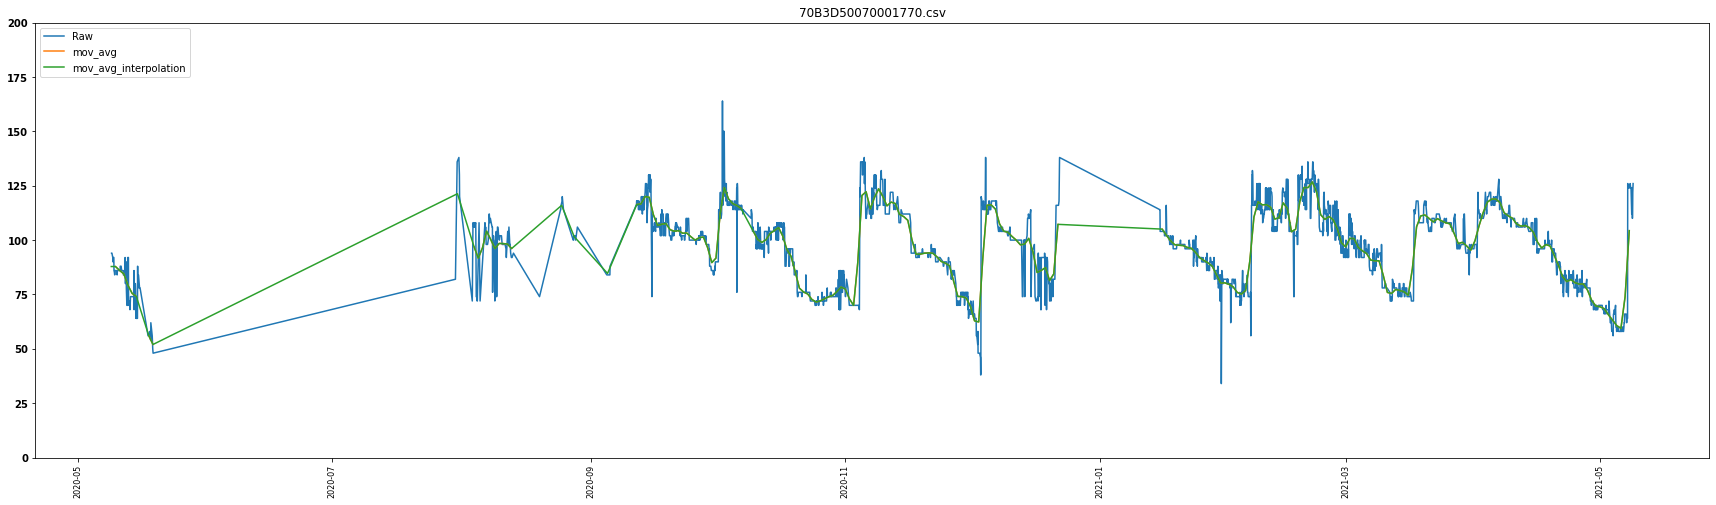

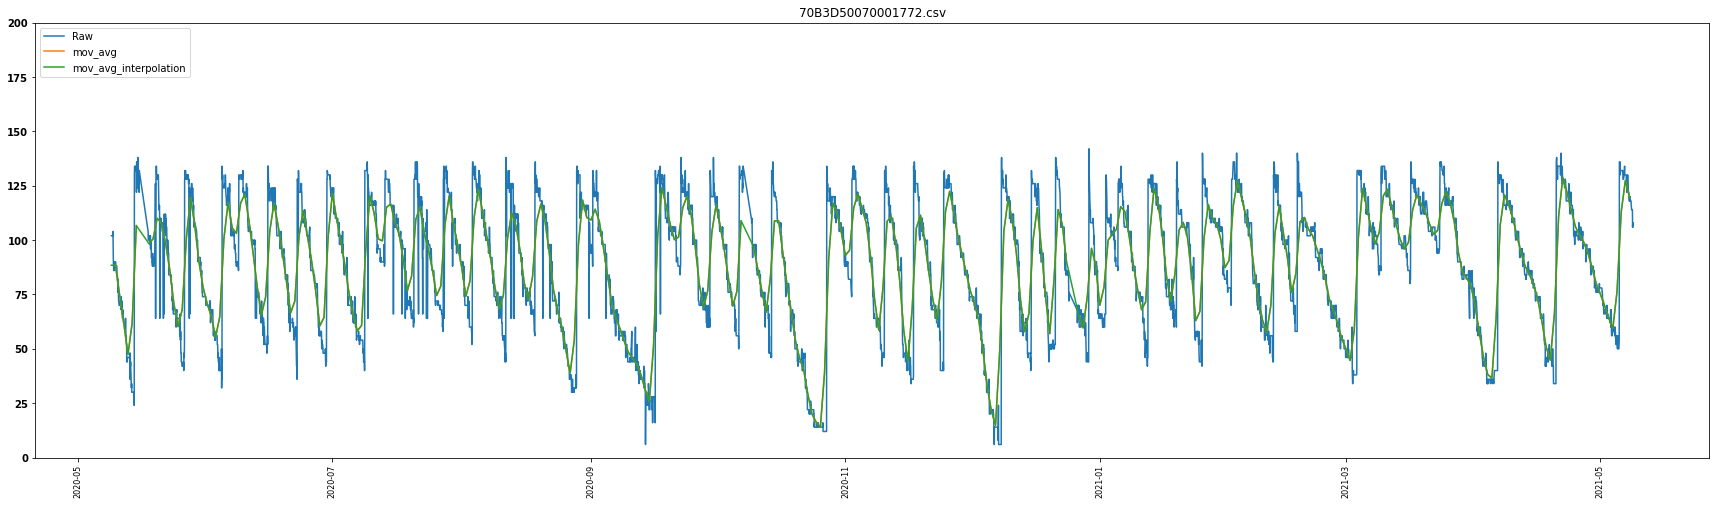

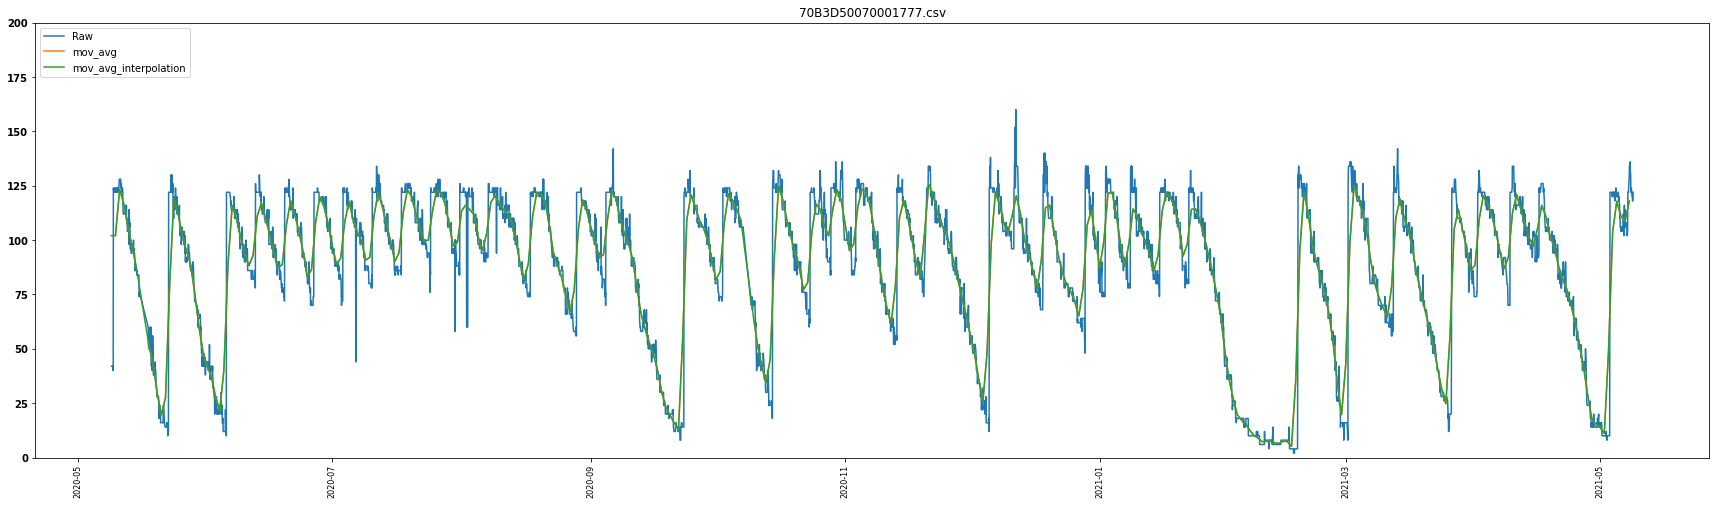

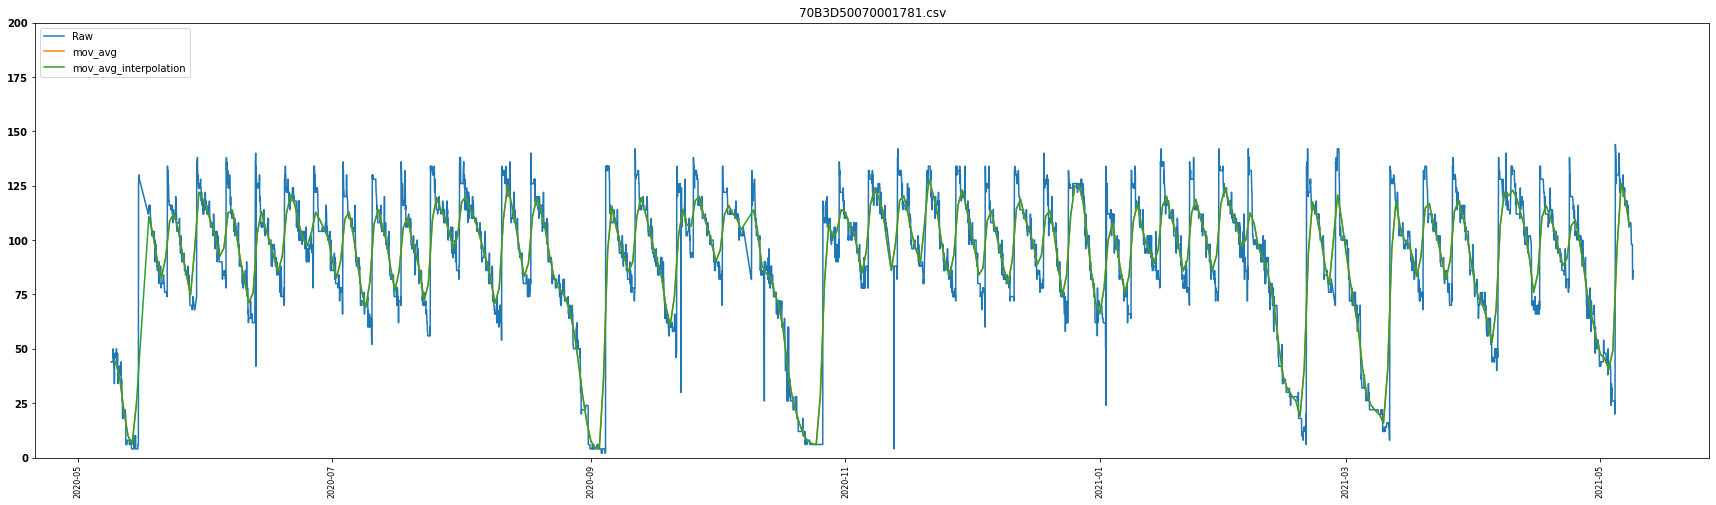

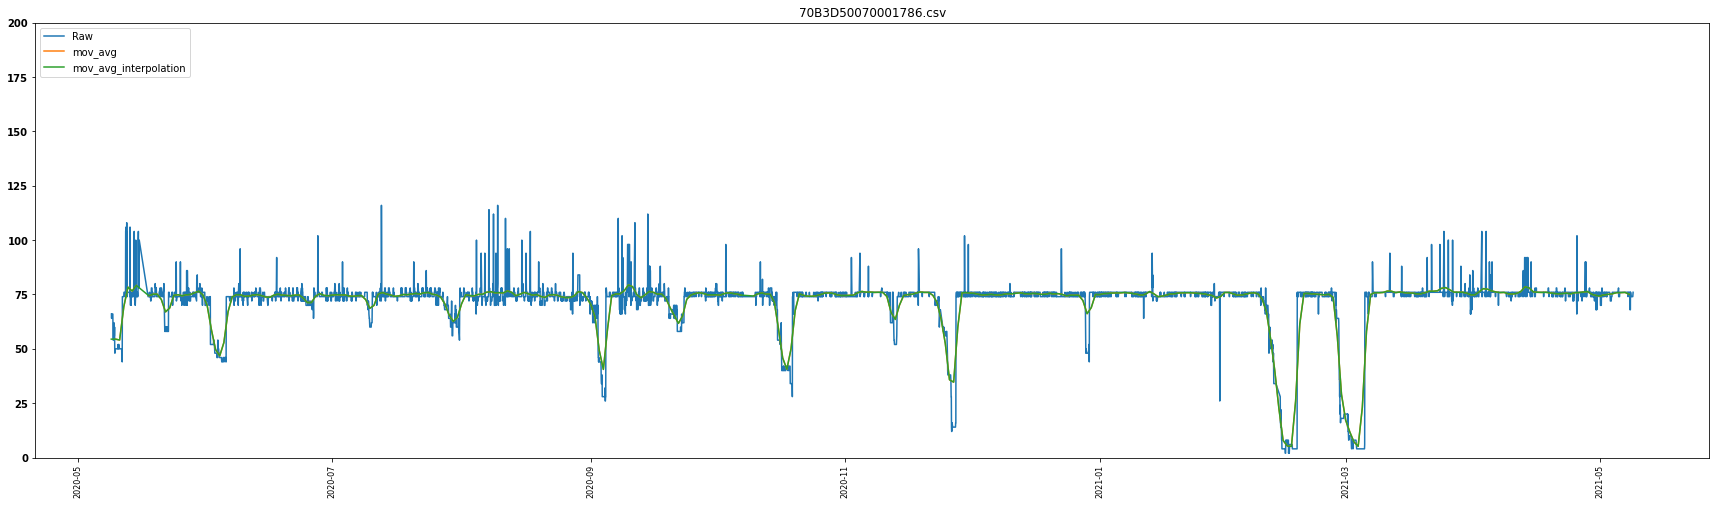

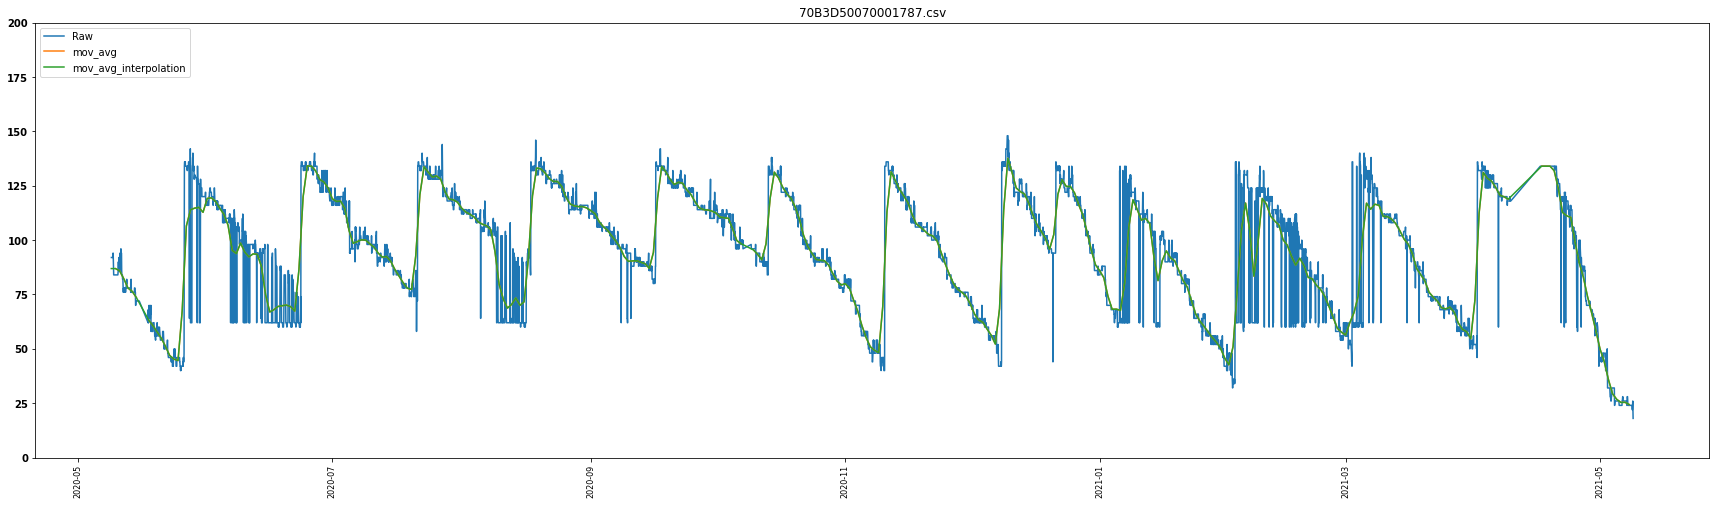

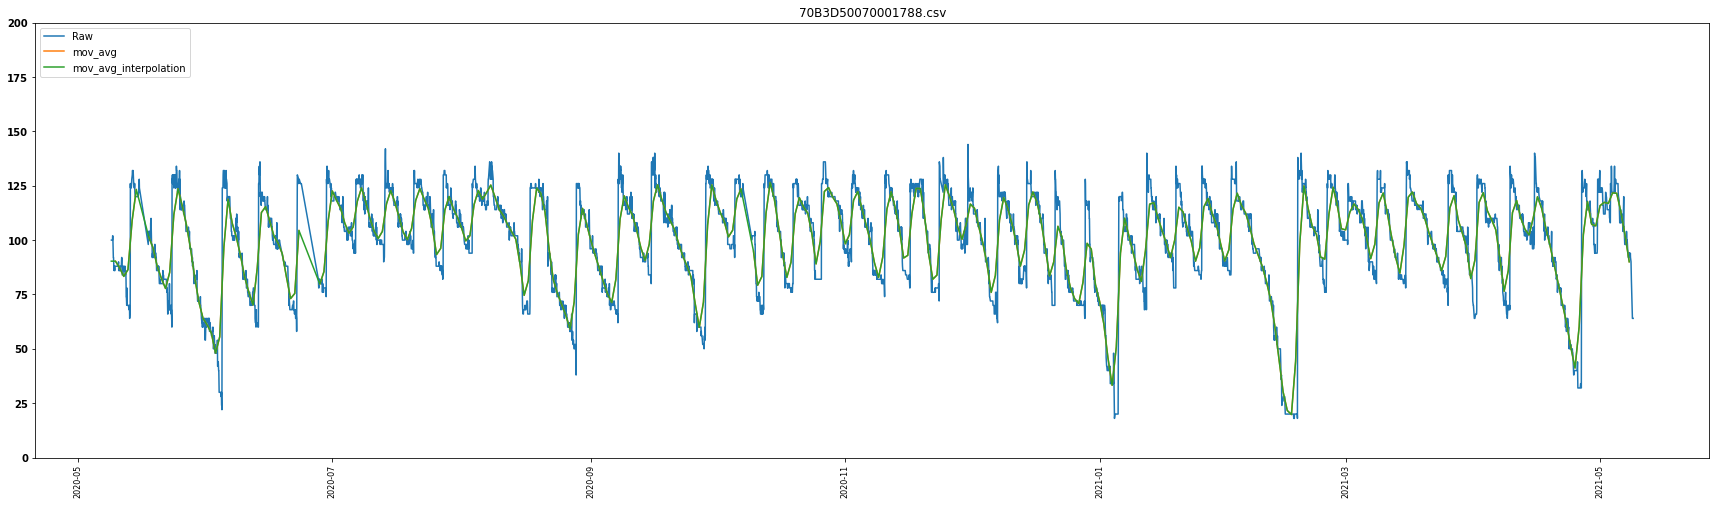

In [4]:
csv_folder = '../data/preprocessed/good_csv/'
csv_files = [csv for csv in os.listdir(csv_folder) if csv.endswith('.csv')]
dfs = []
daily = []

for file in csv_files:
    # import DataFrame
    df = pd.read_csv('../data/preprocessed/CSV/' + file)
    
    df = cleaning_del(df)
    df, grouped = smoothing(df)
    dfs.append(df)
    daily.append(grouped)

    plt.figure(figsize=(30,8))
    plt.ylim((0,200))
    plt.title(file)

    plt.xticks(fontsize=8, rotation=90)
    plt.yticks(fontsize=10, fontweight='bold')
    plt.plot(df['time_stamp'], df['Height'])

    #plt.plot(test['time_stamp'], test['lfilter'])
    #plt.plot(test['time_stamp'], test['mov_avg'])
    #plt.plot(test['time_stamp'], test['min_avg'])
    #plt.plot(daily['Height'])
    plt.plot(grouped['mov_avg'])
    plt.plot(grouped['inter_pol'])


    plt.legend(['Raw', 'mov_avg', 'mov_avg_interpolation', 'min_avg', 'grouped'], loc='upper left')

    plt.show()

Train LSTM based on whole data above, not daily data, not cleaned

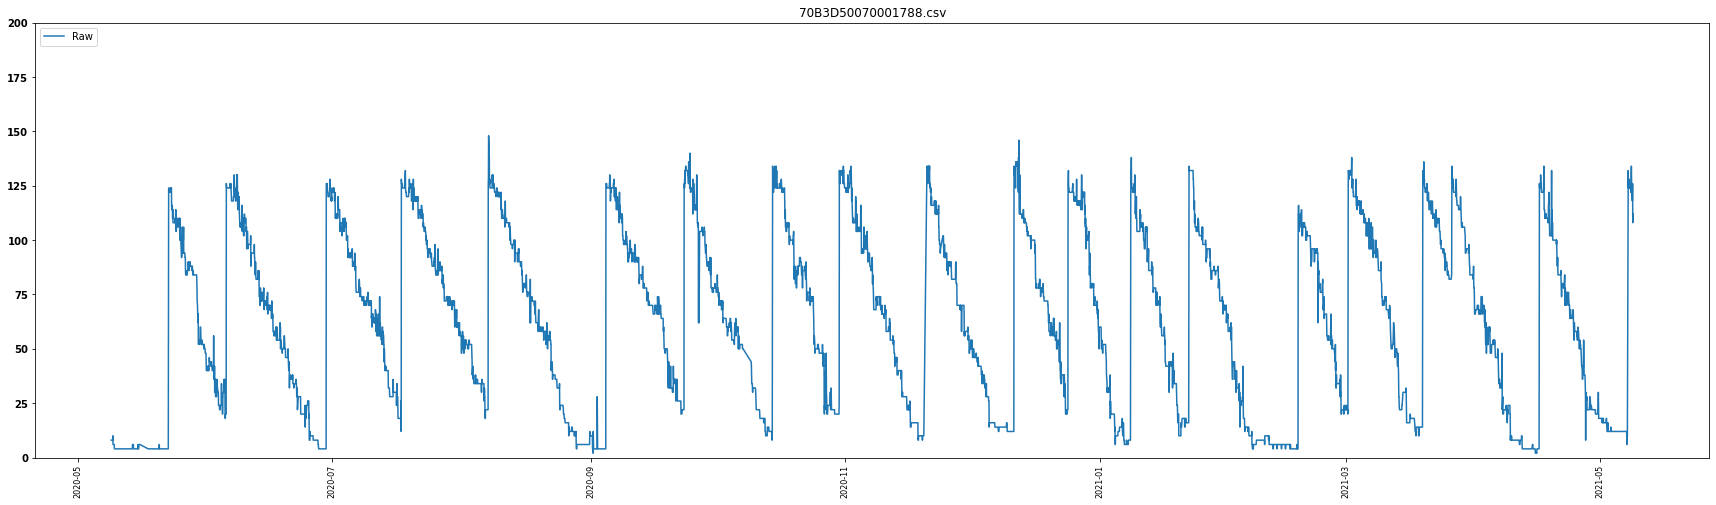

In [5]:
# show what data looks like in the first run 
df1 = dfs[0]

plt.figure(figsize=(30,8))
plt.ylim((0,200))
plt.title(file)

plt.xticks(fontsize=8, rotation=90)
plt.yticks(fontsize=10, fontweight='bold')
plt.plot(df1['time_stamp'], df1['Height'])

#plt.plot(test['time_stamp'], test['lfilter'])
#plt.plot(test['time_stamp'], test['mov_avg'])
#plt.plot(test['time_stamp'], test['min_avg'])
#plt.plot(daily['Height'])
    
#plt.plot(grouped['mov_avg'])
#plt.plot(grouped['inter_pol'])


plt.legend(['Raw', 'mov_avg', 'mov_avg_interpolation', 'min_avg', 'grouped'], loc='upper left')

plt.show()

In [6]:
df1.head()

device_id                 time_stamp  Height  Temperature  Tilt  \
0  70B3D500700016DA 2020-05-09 00:52:00.051726       8         13.0     1   
1  70B3D500700016DA 2020-05-09 01:51:59.856614       8         11.0     1   
2  70B3D500700016DA 2020-05-09 02:51:59.658736       8         11.0     1   
3  70B3D500700016DA 2020-05-09 03:51:59.488678       8         13.0     1   
4  70B3D500700016DA 2020-05-09 04:51:59.293896       8         12.0     2   

    lfilter  mov_avg  min_avg  inter_pol  
0  0.133333      NaN      NaN   4.933333  
1  0.266667      NaN      NaN   4.933333  
2  0.400000      NaN      NaN   4.933333  
3  0.533333      NaN      NaN   4.933333  
4  0.666667      NaN      NaN   4.933333

In [7]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

import numpy
from keras.datasets import imdb
from keras.layers.embeddings import Embedding
from keras.preprocessing import sequence
from tensorflow.keras import activations

from keras.layers import Activation, Dense

from keras.preprocessing.sequence import TimeseriesGenerator
from sklearn.model_selection import train_test_split

import tensorflow as tf

In [61]:
#sample Data
dfs_sampled = []
for df in dfs:
    df2 = df[::12]
    dfs_sampled.append(df2)
    

In [62]:
def create_windows(dfs, length, batch_size, stride):
    features = []
    targets = []
    X = []
    y = []

    # Height as feature and target
    for df in dfs:
        height = df['Height'].to_numpy().tolist()
        
        # apply TimeSeriesGenerator
        ts_generator = TimeseriesGenerator(height,height,length=length, batch_size=batch_size, stride=stride)

        for j in range(len(ts_generator)):
            features.append(ts_generator[j][0])
            targets.append(ts_generator[j][1])
    
    #reshape data for neural network
    for i in range(len(features)):
        x = np.reshape(features[i], (length,1))
        X.append(x)
    X = np.array(X)
    
    y = np.array(targets)
    return X, y

In [63]:
X,y = create_windows(dfs_sampled, 50, 1, 5)
#Split data into train & test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [64]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(3472, 50, 1)
(868, 50, 1)
(3472, 1)
(868, 1)


In [65]:
model = Sequential()
model.add(LSTM(200,activation = 'relu', input_shape= (50, 1)))
#model5.add(LSTM(128, activation='relu', return_sequences=True))
#model5.add(LSTM(128, activation='relu', return_sequences=False))
model.add(Dense(1))

#optimizer = optimizers.Adam(clipvalue=0.5)
adam = tf.keras.optimizers.Adam(learning_rate=0.001, clipnorm=1)
model.compile(optimizer=adam, loss='mse',metrics=['mean_absolute_error'])

In [ ]:
model.fit(X_train, y_train, epochs=50, batch_size=1, validation_data=(X_test, y_test), verbose=1, shuffle=False)

Epoch 1/50
 642/3472 [====>.........................] - ETA: 1:51 - loss: 57301662.1689 - mean_absolute_error: 2296.7832- ETA: 1:50 - loss: 59133748.3144 - mean_absolute_error: 2364.5 - ETA: 1:50 - loss: 58944608.7194 - mean_absol

In [184]:
# visualize prediction

In [59]:
initial_set = X_test[1]

result = []
for i in range(0, 2000):
    x_input = initial_set.reshape((1, 50, 1))
    yhat = model.predict(x_input, verbose=0)
    result.append(yhat[0][0])
    
    initial_set = np.append(initial_set, yhat)
    initial_set = np.delete(initial_set, 0)

NameError: name 'model' is not defined

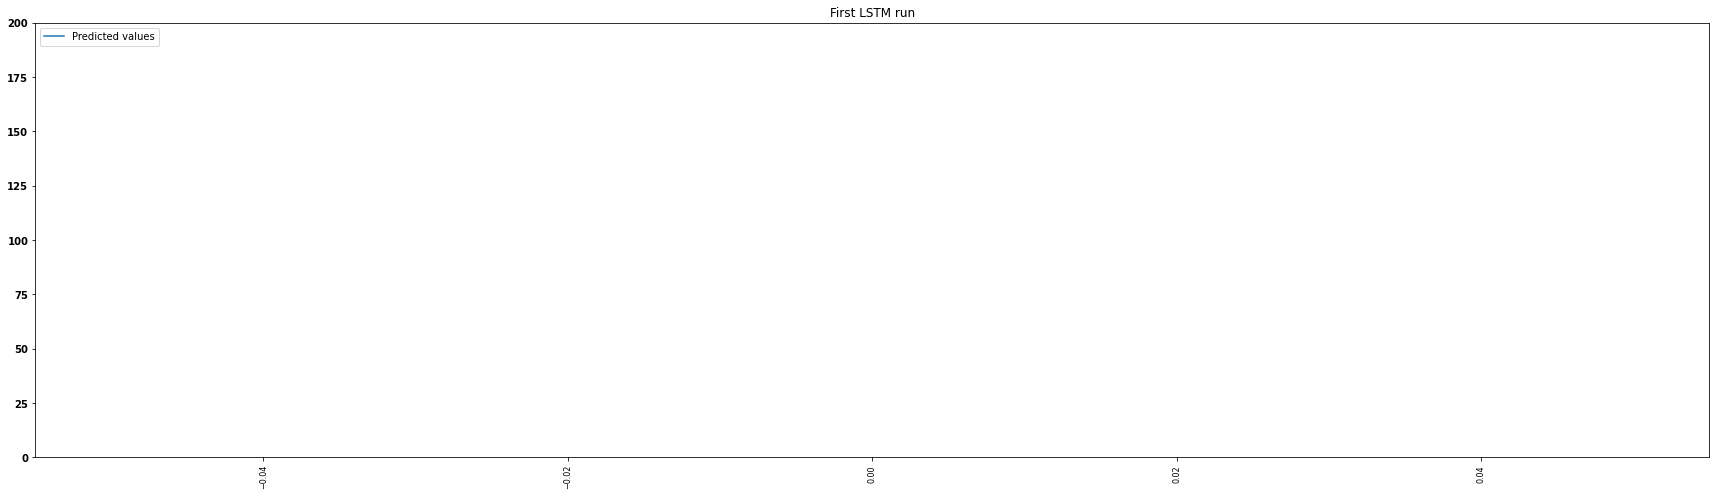

In [60]:
plt.figure(figsize=(30,8))
plt.ylim((0,200))
plt.title("First LSTM run")

plt.xticks(fontsize=8, rotation=90)
plt.yticks(fontsize=10, fontweight='bold')
plt.plot(result)

#plt.plot(test['time_stamp'], test['lfilter'])
#plt.plot(test['time_stamp'], test['mov_avg'])
#plt.plot(test['time_stamp'], test['min_avg'])
#plt.plot(daily['Height'])
    
#plt.plot(grouped['mov_avg'])
#plt.plot(grouped['inter_pol'])


plt.legend(['Predicted values'], loc='upper left')

plt.show()

array([[ 92],
       [ 92],
       [ 96],
       [ 98],
       [ 96],
       [ 96],
       [ 92],
       [ 90],
       [ 90],
       [104]])

Second try with daily data that is smoothed

In [11]:
df_daily_1 = daily[0]
df_daily_1

Height  Temperature      Tilt    lfilter    mov_avg  \
time_stamp                                                            
2020-05-09    6.666667    12.190476  0.904762   1.365079        NaN   
2020-05-10    4.000000    16.150000  0.450000   3.033333   5.333333   
2020-05-11    4.000000     4.857143  1.095238   4.380952   4.000000   
2020-05-12    4.000000    12.523810  0.772727   4.212121   4.000000   
2020-05-13    4.000000    12.200000  0.550000   4.000000   4.000000   
...                ...          ...       ...        ...        ...   
2021-05-04   12.000000     7.555556  1.777778  14.329630  12.058824   
2021-05-05   12.000000     8.470588  2.058824  12.780392  12.000000   
2021-05-06   12.000000     5.923077  2.000000  12.053846  12.000000   
2021-05-07   65.294118     6.470588  1.705882  15.982353  38.647059   
2021-05-08  121.857143    11.916667  1.285714  41.128571  93.575630   

              min_avg         device_id  inter_pol  
time_stamp                                          
2020-05-09        NaN  70B3D500700016DA   5.333333  
2020-05-10        NaN  70B3D500700016DA   5.333333  
2020-05-11   4.000000  70B3D500700016DA   4.000000  
2020-05-12   4.000000  70B3D500700016DA   4.000000  
2020-05-13   4.000000  70B3D500700016DA   4.000000  
...               ...               ...        ...  
2021-05-04  12.000000  70B3D500700016DA  12.058824  
2021-05-05  12.000000  70B3D500700016DA  12.000000  
2021-05-06  12.000000  70B3D500700016DA  12.000000  
2021-05-07   8.470588  70B3D500700016DA  38.647059  
2021-05-08   6.000000  70B3D500700016DA  93.575630  

[365 rows x 8 columns]

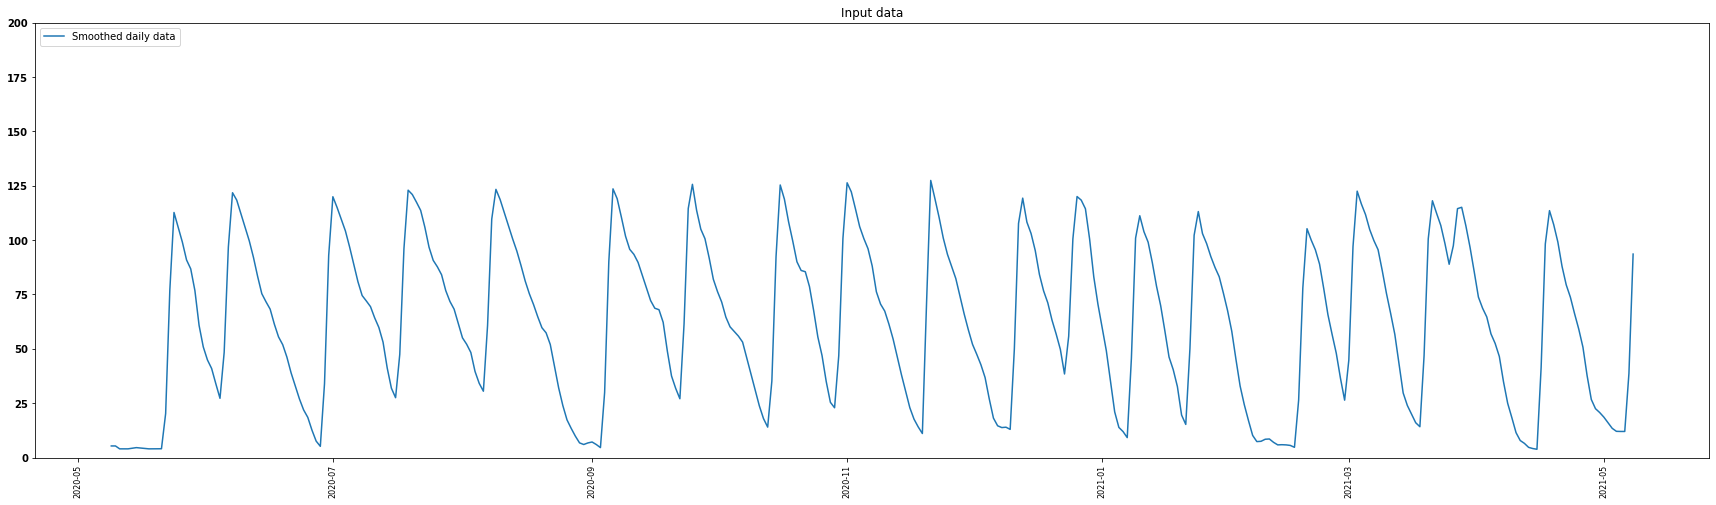

In [12]:
plt.figure(figsize=(30,8))
plt.ylim((0,200))
plt.title("Input data")

plt.xticks(fontsize=8, rotation=90)
plt.yticks(fontsize=10, fontweight='bold')
plt.plot(df_daily_1['inter_pol'])

#plt.plot(test['time_stamp'], test['lfilter'])
#plt.plot(test['time_stamp'], test['mov_avg'])
#plt.plot(test['time_stamp'], test['min_avg'])
#plt.plot(daily['Height'])
    
#plt.plot(grouped['mov_avg'])
#plt.plot(grouped['inter_pol'])


plt.legend(['Smoothed daily data'], loc='upper left')

plt.show()

In [13]:
# create lstm input data 
dfs_daily = []
for d in daily: 
    df = pd.DataFrame()
    df['Height'] = d['inter_pol']
    dfs_daily.append(df)
    
len(dfs_daily)

42

In [48]:
X_2,y_2 = create_windows(dfs_daily, 100, 1, 1)
#Split data into train & test set
X_train_2, X_test_2, y_train_2, y_test_2 = train_test_split(X_2, y_2, test_size=0.2)

In [49]:
print(X_train_2.shape)
print(X_test_2.shape)
print(y_train_2.shape)
print(y_test_2.shape)

(8882, 100, 1)
(2221, 100, 1)
(8882, 1)
(2221, 1)


In [56]:
model2 = Sequential()
model2.add(LSTM(200,activation = 'relu', input_shape= (100, 1), dropout=0.2))
#model2.add(LSTM(128, activation='relu', return_sequences=True))
#model2.add(LSTM(128, activation='relu', return_sequences=False))
model2.add(Dense(1))

#optimizer = optimizers.Adam(clipvalue=0.5)
adam2 = tf.keras.optimizers.Adam(learning_rate=0.001, clipnorm=1)
model2.compile(optimizer=adam2, loss='mse',metrics=['mean_absolute_error'])

In [58]:
model2.fit(X_train_2, y_train_2, epochs=20, batch_size=1, validation_data=(X_test_2, y_test_2), verbose=1, shuffle=False)

Epoch 1/20
8882/8882 [==============================] - 503s 56ms/step - loss: nan - mean_absolute_error: nan - val_loss: nan - val_mean_absolute_error: nan
Epoch 2/20
4768/8882 [===============>..............] - ETA: 4:16 - loss: nan - mean_absolute_error: nan- ETA: 4:16 - loss: nan - mean_absolute_err

KeyboardInterrupt: 

In [52]:
# visualize prediction

In [54]:
initial_set_2 = X_test_2[6]

result2 = []
for i in range(0, 365):
    x_input = initial_set_2.reshape((1, 100, 1))
    yhat = model2.predict(x_input, verbose=0)
    result2.append(yhat[0][0])
    
    initial_set_2 = np.append(initial_set_2, yhat)
    initial_set_2 = np.delete(initial_set_2, 0)

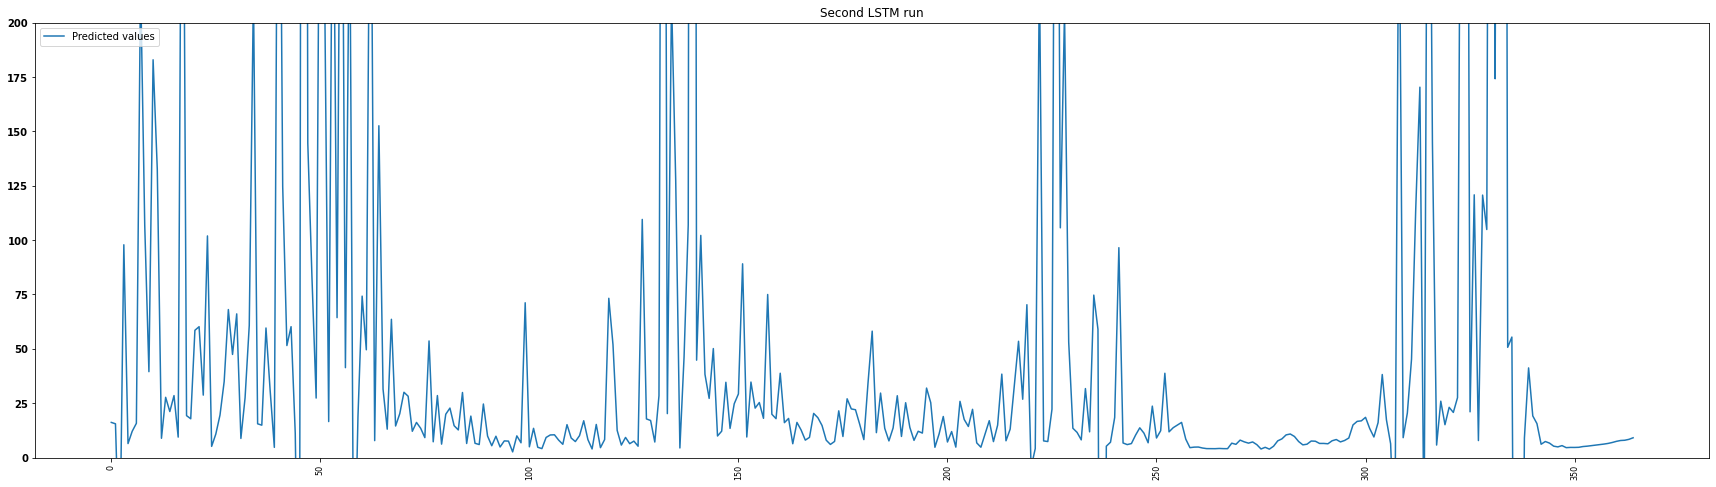

In [55]:
plt.figure(figsize=(30,8))
plt.ylim((0,200))
plt.title("Second LSTM run")

plt.xticks(fontsize=8, rotation=90)
plt.yticks(fontsize=10, fontweight='bold')
plt.plot(result2)

#plt.plot(test['time_stamp'], test['lfilter'])
#plt.plot(test['time_stamp'], test['mov_avg'])
#plt.plot(test['time_stamp'], test['min_avg'])
#plt.plot(daily['Height'])
    
#plt.plot(grouped['mov_avg'])
#plt.plot(grouped['inter_pol'])


plt.legend(['Predicted values'], loc='upper left')

plt.show()